# Afriat

In [1]:
ood_seed = 1

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('0.0', 'Periportal', 'Control')

Removed datapoint: 2659


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: znhhi2oo
Name: civilized-nerf-herder-229
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/znhhi2oo
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_225404-znhhi2oo/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 444,3286,9386
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 444,2572,1658,3458,1635,3349
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4480,8636
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 102,823,2353
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 102,630,450,832,414,850
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1104,2174
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:11<1:51:15, 11.15s/it]

Epoch 1/600:   0%|          | 1/600 [00:11<1:51:15, 11.15s/it, v_num=oo_1, total_loss_train=3.86e+3, kl_local_train=48.9]

Epoch 2/600:   0%|          | 1/600 [00:11<1:51:15, 11.15s/it, v_num=oo_1, total_loss_train=3.86e+3, kl_local_train=48.9]

Epoch 2/600:   0%|          | 2/600 [00:21<1:45:34, 10.59s/it, v_num=oo_1, total_loss_train=3.86e+3, kl_local_train=48.9]

Epoch 2/600:   0%|          | 2/600 [00:21<1:45:34, 10.59s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=76.5]

Epoch 3/600:   0%|          | 2/600 [00:21<1:45:34, 10.59s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=76.5]

Epoch 3/600:   0%|          | 3/600 [00:31<1:43:24, 10.39s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=76.5]

Epoch 3/600:   0%|          | 3/600 [00:31<1:43:24, 10.39s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=79.6]

Epoch 4/600:   0%|          | 3/600 [00:31<1:43:24, 10.39s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=79.6]

Epoch 4/600:   1%|          | 4/600 [00:41<1:42:07, 10.28s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=79.6]

Epoch 4/600:   1%|          | 4/600 [00:41<1:42:07, 10.28s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=78.7]

Epoch 5/600:   1%|          | 4/600 [00:41<1:42:07, 10.28s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=78.7]

Epoch 5/600:   1%|          | 5/600 [00:51<1:41:32, 10.24s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=78.7]

Epoch 5/600:   1%|          | 5/600 [00:51<1:41:32, 10.24s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=75.2]

Epoch 6/600:   1%|          | 5/600 [00:51<1:41:32, 10.24s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=75.2]

Epoch 6/600:   1%|          | 6/600 [01:01<1:41:03, 10.21s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=75.2]

Epoch 6/600:   1%|          | 6/600 [01:01<1:41:03, 10.21s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=69.5]

Epoch 7/600:   1%|          | 6/600 [01:01<1:41:03, 10.21s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=69.5]

Epoch 7/600:   1%|          | 7/600 [01:12<1:40:44, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=69.5]

Epoch 7/600:   1%|          | 7/600 [01:12<1:40:44, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=61.7]

Epoch 8/600:   1%|          | 7/600 [01:12<1:40:44, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=61.7]

Epoch 8/600:   1%|▏         | 8/600 [01:22<1:40:34, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=61.7]

Epoch 8/600:   1%|▏         | 8/600 [01:22<1:40:34, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=48.1]

Epoch 9/600:   1%|▏         | 8/600 [01:22<1:40:34, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=48.1]

Epoch 9/600:   2%|▏         | 9/600 [01:32<1:40:47, 10.23s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=48.1]

Epoch 9/600:   2%|▏         | 9/600 [01:32<1:40:47, 10.23s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=35.9]

Epoch 10/600:   2%|▏         | 9/600 [01:32<1:40:47, 10.23s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=35.9]

Epoch 10/600:   2%|▏         | 10/600 [01:42<1:40:36, 10.23s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=35.9]

Epoch 10/600:   2%|▏         | 10/600 [01:42<1:40:36, 10.23s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=38.7]

Epoch 11/600:   2%|▏         | 10/600 [01:42<1:40:36, 10.23s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=38.7]

Epoch 11/600:   2%|▏         | 11/600 [01:52<1:40:09, 10.20s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=38.7]

Epoch 11/600:   2%|▏         | 11/600 [01:52<1:40:09, 10.20s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=87.9]

Epoch 12/600:   2%|▏         | 11/600 [01:52<1:40:09, 10.20s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=87.9]

Epoch 12/600:   2%|▏         | 12/600 [02:03<1:39:50, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=87.9]

Epoch 12/600:   2%|▏         | 12/600 [02:03<1:39:50, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=181] 

Epoch 13/600:   2%|▏         | 12/600 [02:03<1:39:50, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=181]

Epoch 13/600:   2%|▏         | 13/600 [02:13<1:39:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=181]

Epoch 13/600:   2%|▏         | 13/600 [02:13<1:39:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=277]

Epoch 14/600:   2%|▏         | 13/600 [02:13<1:39:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=277]

Epoch 14/600:   2%|▏         | 14/600 [02:23<1:39:33, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=277]

Epoch 14/600:   2%|▏         | 14/600 [02:23<1:39:33, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=368]

Epoch 15/600:   2%|▏         | 14/600 [02:23<1:39:33, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=368]

Epoch 15/600:   2%|▎         | 15/600 [02:33<1:39:24, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=368]

Epoch 15/600:   2%|▎         | 15/600 [02:33<1:39:24, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=404]

Epoch 16/600:   2%|▎         | 15/600 [02:33<1:39:24, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=404]

Epoch 16/600:   3%|▎         | 16/600 [02:43<1:39:03, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=404]

Epoch 16/600:   3%|▎         | 16/600 [02:43<1:39:03, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=403]

Epoch 17/600:   3%|▎         | 16/600 [02:43<1:39:03, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=403]

Epoch 17/600:   3%|▎         | 17/600 [02:54<1:38:53, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=403]

Epoch 17/600:   3%|▎         | 17/600 [02:54<1:38:53, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=417]

Epoch 18/600:   3%|▎         | 17/600 [02:54<1:38:53, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=417]

Epoch 18/600:   3%|▎         | 18/600 [03:04<1:39:01, 10.21s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=417]

Epoch 18/600:   3%|▎         | 18/600 [03:04<1:39:01, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=449]

Epoch 19/600:   3%|▎         | 18/600 [03:04<1:39:01, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=449]

Epoch 19/600:   3%|▎         | 19/600 [03:14<1:38:31, 10.17s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=449]

Epoch 19/600:   3%|▎         | 19/600 [03:14<1:38:31, 10.17s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=516]

Epoch 20/600:   3%|▎         | 19/600 [03:14<1:38:31, 10.17s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=516]

Epoch 20/600:   3%|▎         | 20/600 [03:24<1:38:31, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=516]

Epoch 20/600:   3%|▎         | 20/600 [03:24<1:38:31, 10.19s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=628]

Epoch 21/600:   3%|▎         | 20/600 [03:24<1:38:31, 10.19s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=628]

Epoch 21/600:   4%|▎         | 21/600 [03:34<1:38:24, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=628]

Epoch 21/600:   4%|▎         | 21/600 [03:34<1:38:24, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=634]

Epoch 22/600:   4%|▎         | 21/600 [03:34<1:38:24, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=634]

Epoch 22/600:   4%|▎         | 22/600 [03:45<1:38:27, 10.22s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=634]

Epoch 22/600:   4%|▎         | 22/600 [03:45<1:38:27, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=457]

Epoch 23/600:   4%|▎         | 22/600 [03:45<1:38:27, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=457]

Epoch 23/600:   4%|▍         | 23/600 [03:55<1:38:19, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=457]

Epoch 23/600:   4%|▍         | 23/600 [03:55<1:38:19, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=344]

Epoch 24/600:   4%|▍         | 23/600 [03:55<1:38:19, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=344]

Epoch 24/600:   4%|▍         | 24/600 [04:05<1:38:08, 10.22s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=344]

Epoch 24/600:   4%|▍         | 24/600 [04:05<1:38:08, 10.22s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=290]

Epoch 25/600:   4%|▍         | 24/600 [04:05<1:38:08, 10.22s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=290]

Epoch 25/600:   4%|▍         | 25/600 [04:15<1:37:59, 10.22s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=290]

Epoch 25/600:   4%|▍         | 25/600 [04:15<1:37:59, 10.22s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=259]

Epoch 26/600:   4%|▍         | 25/600 [04:15<1:37:59, 10.22s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=259]

Epoch 26/600:   4%|▍         | 26/600 [04:25<1:37:31, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=259]

Epoch 26/600:   4%|▍         | 26/600 [04:25<1:37:31, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=236]

Epoch 27/600:   4%|▍         | 26/600 [04:25<1:37:31, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=236]

Epoch 27/600:   4%|▍         | 27/600 [04:36<1:37:20, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=236]

Epoch 27/600:   4%|▍         | 27/600 [04:36<1:37:20, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 28/600:   4%|▍         | 27/600 [04:36<1:37:20, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 28/600:   5%|▍         | 28/600 [04:46<1:37:04, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 28/600:   5%|▍         | 28/600 [04:46<1:37:04, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 29/600:   5%|▍         | 28/600 [04:46<1:37:04, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 29/600:   5%|▍         | 29/600 [04:56<1:36:38, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 29/600:   5%|▍         | 29/600 [04:56<1:36:38, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=212]

Epoch 30/600:   5%|▍         | 29/600 [04:56<1:36:38, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=212]

Epoch 30/600:   5%|▌         | 30/600 [05:06<1:36:35, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=212]

Epoch 30/600:   5%|▌         | 30/600 [05:06<1:36:35, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=200]

Epoch 31/600:   5%|▌         | 30/600 [05:06<1:36:35, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=200]

Epoch 31/600:   5%|▌         | 31/600 [05:16<1:36:21, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=200]

Epoch 31/600:   5%|▌         | 31/600 [05:16<1:36:21, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=199]

Epoch 32/600:   5%|▌         | 31/600 [05:16<1:36:21, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=199]

Epoch 32/600:   5%|▌         | 32/600 [05:26<1:36:05, 10.15s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=199]

Epoch 32/600:   5%|▌         | 32/600 [05:26<1:36:05, 10.15s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=190]

Epoch 33/600:   5%|▌         | 32/600 [05:26<1:36:05, 10.15s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=190]

Epoch 33/600:   6%|▌         | 33/600 [05:36<1:35:43, 10.13s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=190]

Epoch 33/600:   6%|▌         | 33/600 [05:36<1:35:43, 10.13s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 34/600:   6%|▌         | 33/600 [05:36<1:35:43, 10.13s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 34/600:   6%|▌         | 34/600 [05:47<1:35:39, 10.14s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=183]

Epoch 34/600:   6%|▌         | 34/600 [05:47<1:35:39, 10.14s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 34/600 [05:47<1:35:39, 10.14s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 35/600 [05:57<1:35:40, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 35/600:   6%|▌         | 35/600 [05:57<1:35:40, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 36/600:   6%|▌         | 35/600 [05:57<1:35:40, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 36/600:   6%|▌         | 36/600 [06:07<1:35:33, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=184]

Epoch 36/600:   6%|▌         | 36/600 [06:07<1:35:33, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 37/600:   6%|▌         | 36/600 [06:07<1:35:33, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 37/600:   6%|▌         | 37/600 [06:17<1:35:21, 10.16s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=185]

Epoch 37/600:   6%|▌         | 37/600 [06:17<1:35:21, 10.16s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=191]

Epoch 38/600:   6%|▌         | 37/600 [06:17<1:35:21, 10.16s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=191]

Epoch 38/600:   6%|▋         | 38/600 [06:27<1:35:12, 10.16s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=191]

Epoch 38/600:   6%|▋         | 38/600 [06:27<1:35:12, 10.16s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=185]

Epoch 39/600:   6%|▋         | 38/600 [06:27<1:35:12, 10.16s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=185]

Epoch 39/600:   6%|▋         | 39/600 [06:38<1:35:10, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=185]

Epoch 39/600:   6%|▋         | 39/600 [06:38<1:35:10, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=186]

Epoch 40/600:   6%|▋         | 39/600 [06:38<1:35:10, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=186]

Epoch 40/600:   7%|▋         | 40/600 [06:48<1:35:00, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=186]

Epoch 40/600:   7%|▋         | 40/600 [06:48<1:35:00, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 40/600 [06:48<1:35:00, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 41/600 [06:58<1:34:48, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=178]

Epoch 41/600:   7%|▋         | 41/600 [06:58<1:34:48, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 42/600:   7%|▋         | 41/600 [06:58<1:34:48, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 42/600:   7%|▋         | 42/600 [07:08<1:34:40, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=183]

Epoch 42/600:   7%|▋         | 42/600 [07:08<1:34:40, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=187]

Epoch 43/600:   7%|▋         | 42/600 [07:08<1:34:40, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=187]

Epoch 43/600:   7%|▋         | 43/600 [07:18<1:34:34, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=187]

Epoch 43/600:   7%|▋         | 43/600 [07:18<1:34:34, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=185]

Epoch 44/600:   7%|▋         | 43/600 [07:18<1:34:34, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=185]

Epoch 44/600:   7%|▋         | 44/600 [07:28<1:34:22, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=185]

Epoch 44/600:   7%|▋         | 44/600 [07:28<1:34:22, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 45/600:   7%|▋         | 44/600 [07:28<1:34:22, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [07:39<1:34:08, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 45/600:   8%|▊         | 45/600 [07:39<1:34:08, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 46/600:   8%|▊         | 45/600 [07:39<1:34:08, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 46/600:   8%|▊         | 46/600 [07:49<1:33:48, 10.16s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=184]

Epoch 46/600:   8%|▊         | 46/600 [07:49<1:33:48, 10.16s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=183]

Epoch 47/600:   8%|▊         | 46/600 [07:49<1:33:48, 10.16s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=183]

Epoch 47/600:   8%|▊         | 47/600 [07:59<1:33:44, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=183]

Epoch 47/600:   8%|▊         | 47/600 [07:59<1:33:44, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 48/600:   8%|▊         | 47/600 [07:59<1:33:44, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 48/600:   8%|▊         | 48/600 [08:09<1:33:35, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 48/600:   8%|▊         | 48/600 [08:09<1:33:35, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=185]

Epoch 49/600:   8%|▊         | 48/600 [08:09<1:33:35, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=185]

Epoch 49/600:   8%|▊         | 49/600 [08:19<1:33:35, 10.19s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=185]

Epoch 49/600:   8%|▊         | 49/600 [08:19<1:33:35, 10.19s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 50/600:   8%|▊         | 49/600 [08:19<1:33:35, 10.19s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 50/600:   8%|▊         | 50/600 [08:30<1:33:49, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=182]

Epoch 50/600:   8%|▊         | 50/600 [08:30<1:33:49, 10.23s/it, v_num=oo_1, total_loss_train=3.3e+3, kl_local_train=186] 

Epoch 51/600:   8%|▊         | 50/600 [08:30<1:33:49, 10.23s/it, v_num=oo_1, total_loss_train=3.3e+3, kl_local_train=186]

Epoch 51/600:   8%|▊         | 51/600 [08:40<1:33:34, 10.23s/it, v_num=oo_1, total_loss_train=3.3e+3, kl_local_train=186]

Epoch 51/600:   8%|▊         | 51/600 [08:40<1:33:34, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 52/600:   8%|▊         | 51/600 [08:40<1:33:34, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 52/600:   9%|▊         | 52/600 [08:50<1:33:08, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 52/600:   9%|▊         | 52/600 [08:50<1:33:08, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 53/600:   9%|▊         | 52/600 [08:50<1:33:08, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 53/600:   9%|▉         | 53/600 [09:00<1:33:01, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 53/600:   9%|▉         | 53/600 [09:00<1:33:01, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 54/600:   9%|▉         | 53/600 [09:00<1:33:01, 10.20s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 54/600:   9%|▉         | 54/600 [09:10<1:32:33, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=186]

Epoch 54/600:   9%|▉         | 54/600 [09:10<1:32:33, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=178]

Epoch 55/600:   9%|▉         | 54/600 [09:10<1:32:33, 10.17s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=178]

Epoch 55/600:   9%|▉         | 55/600 [09:20<1:32:26, 10.18s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=178]

Epoch 55/600:   9%|▉         | 55/600 [09:20<1:32:26, 10.18s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=179]

Epoch 56/600:   9%|▉         | 55/600 [09:21<1:32:26, 10.18s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=179]

Epoch 56/600:   9%|▉         | 56/600 [09:31<1:32:42, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=179]

Epoch 56/600:   9%|▉         | 56/600 [09:31<1:32:42, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=177]

Epoch 57/600:   9%|▉         | 56/600 [09:31<1:32:42, 10.23s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=177]

Epoch 57/600:  10%|▉         | 57/600 [09:41<1:32:25, 10.21s/it, v_num=oo_1, total_loss_train=3.29e+3, kl_local_train=177]

Epoch 57/600:  10%|▉         | 57/600 [09:41<1:32:25, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=177]

Epoch 58/600:  10%|▉         | 57/600 [09:41<1:32:25, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=177]

Epoch 58/600:  10%|▉         | 58/600 [09:51<1:32:16, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=177]

Epoch 58/600:  10%|▉         | 58/600 [09:51<1:32:16, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 59/600:  10%|▉         | 58/600 [09:51<1:32:16, 10.21s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 59/600:  10%|▉         | 59/600 [10:01<1:31:57, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=178]

Epoch 59/600:  10%|▉         | 59/600 [10:01<1:31:57, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=175]

Epoch 60/600:  10%|▉         | 59/600 [10:01<1:31:57, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=175]

Epoch 60/600:  10%|█         | 60/600 [10:12<1:31:39, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=175]

Epoch 60/600:  10%|█         | 60/600 [10:12<1:31:39, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 61/600:  10%|█         | 60/600 [10:12<1:31:39, 10.18s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 61/600:  10%|█         | 61/600 [10:22<1:31:32, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 61/600:  10%|█         | 61/600 [10:22<1:31:32, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=171]

Epoch 62/600:  10%|█         | 61/600 [10:22<1:31:32, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=171]

Epoch 62/600:  10%|█         | 62/600 [10:32<1:31:20, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=171]

Epoch 62/600:  10%|█         | 62/600 [10:32<1:31:20, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=170]

Epoch 63/600:  10%|█         | 62/600 [10:32<1:31:20, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=170]

Epoch 63/600:  10%|█         | 63/600 [10:42<1:31:11, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=170]

Epoch 63/600:  10%|█         | 63/600 [10:42<1:31:11, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 64/600:  10%|█         | 63/600 [10:42<1:31:11, 10.19s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 64/600:  11%|█         | 64/600 [10:52<1:31:07, 10.20s/it, v_num=oo_1, total_loss_train=3.28e+3, kl_local_train=172]

Epoch 64/600:  11%|█         | 64/600 [10:52<1:31:07, 10.20s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 65/600:  11%|█         | 64/600 [10:52<1:31:07, 10.20s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 65/600:  11%|█         | 65/600 [11:02<1:30:47, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 65/600:  11%|█         | 65/600 [11:02<1:30:47, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 66/600:  11%|█         | 65/600 [11:03<1:30:47, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 66/600:  11%|█         | 66/600 [11:13<1:30:36, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 66/600:  11%|█         | 66/600 [11:13<1:30:36, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 66/600 [11:13<1:30:36, 10.18s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 67/600 [11:23<1:30:29, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=167]

Epoch 67/600:  11%|█         | 67/600 [11:23<1:30:29, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 68/600:  11%|█         | 67/600 [11:23<1:30:29, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 68/600:  11%|█▏        | 68/600 [11:33<1:30:12, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 68/600:  11%|█▏        | 68/600 [11:33<1:30:12, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 69/600:  11%|█▏        | 68/600 [11:33<1:30:12, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 69/600:  12%|█▏        | 69/600 [11:43<1:29:59, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=171]

Epoch 69/600:  12%|█▏        | 69/600 [11:43<1:29:59, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 70/600:  12%|█▏        | 69/600 [11:43<1:29:59, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 70/600:  12%|█▏        | 70/600 [11:53<1:29:58, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=170]

Epoch 70/600:  12%|█▏        | 70/600 [11:53<1:29:58, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=168]

Epoch 71/600:  12%|█▏        | 70/600 [11:53<1:29:58, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=168]

Epoch 71/600:  12%|█▏        | 71/600 [12:04<1:29:52, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=168]

Epoch 71/600:  12%|█▏        | 71/600 [12:04<1:29:52, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=166]

Epoch 72/600:  12%|█▏        | 71/600 [12:04<1:29:52, 10.19s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=166]

Epoch 72/600:  12%|█▏        | 72/600 [12:14<1:29:30, 10.17s/it, v_num=oo_1, total_loss_train=3.27e+3, kl_local_train=166]

Epoch 72/600:  12%|█▏        | 72/600 [12:14<1:29:30, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=163]

Epoch 73/600:  12%|█▏        | 72/600 [12:14<1:29:30, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=163]

Epoch 73/600:  12%|█▏        | 73/600 [12:24<1:29:21, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=163]

Epoch 73/600:  12%|█▏        | 73/600 [12:24<1:29:21, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 74/600:  12%|█▏        | 73/600 [12:24<1:29:21, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 74/600:  12%|█▏        | 74/600 [12:34<1:29:11, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 74/600:  12%|█▏        | 74/600 [12:34<1:29:11, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=164]

Epoch 75/600:  12%|█▏        | 74/600 [12:34<1:29:11, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=164]

Epoch 75/600:  12%|█▎        | 75/600 [12:44<1:29:02, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=164]

Epoch 75/600:  12%|█▎        | 75/600 [12:44<1:29:02, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 76/600:  12%|█▎        | 75/600 [12:44<1:29:02, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 76/600:  13%|█▎        | 76/600 [12:54<1:28:55, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=162]

Epoch 76/600:  13%|█▎        | 76/600 [12:54<1:28:55, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 77/600:  13%|█▎        | 76/600 [12:54<1:28:55, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 77/600:  13%|█▎        | 77/600 [13:05<1:28:49, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 77/600:  13%|█▎        | 77/600 [13:05<1:28:49, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=161]

Epoch 78/600:  13%|█▎        | 77/600 [13:05<1:28:49, 10.19s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=161]

Epoch 78/600:  13%|█▎        | 78/600 [13:15<1:28:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=161]

Epoch 78/600:  13%|█▎        | 78/600 [13:15<1:28:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=159]

Epoch 79/600:  13%|█▎        | 78/600 [13:15<1:28:35, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=159]

Epoch 79/600:  13%|█▎        | 79/600 [13:25<1:28:25, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=159]

Epoch 79/600:  13%|█▎        | 79/600 [13:25<1:28:25, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 80/600:  13%|█▎        | 79/600 [13:25<1:28:25, 10.18s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 80/600:  13%|█▎        | 80/600 [13:35<1:28:08, 10.17s/it, v_num=oo_1, total_loss_train=3.26e+3, kl_local_train=158]

Epoch 80/600:  13%|█▎        | 80/600 [13:35<1:28:08, 10.17s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 81/600:  13%|█▎        | 80/600 [13:35<1:28:08, 10.17s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 81/600:  14%|█▎        | 81/600 [13:45<1:28:07, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 81/600:  14%|█▎        | 81/600 [13:45<1:28:07, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 82/600:  14%|█▎        | 81/600 [13:45<1:28:07, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 82/600:  14%|█▎        | 82/600 [13:56<1:27:53, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 82/600:  14%|█▎        | 82/600 [13:56<1:27:53, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 83/600:  14%|█▎        | 82/600 [13:56<1:27:53, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 83/600:  14%|█▍        | 83/600 [14:06<1:27:47, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 83/600:  14%|█▍        | 83/600 [14:06<1:27:47, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 83/600 [14:06<1:27:47, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 84/600 [14:16<1:27:35, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=153]

Epoch 84/600:  14%|█▍        | 84/600 [14:16<1:27:35, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 85/600:  14%|█▍        | 84/600 [14:16<1:27:35, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 85/600:  14%|█▍        | 85/600 [14:26<1:27:26, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=154]

Epoch 85/600:  14%|█▍        | 85/600 [14:26<1:27:26, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 85/600 [14:26<1:27:26, 10.19s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 86/600 [14:36<1:27:34, 10.22s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=150]

Epoch 86/600:  14%|█▍        | 86/600 [14:36<1:27:34, 10.22s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 86/600 [14:36<1:27:34, 10.22s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 87/600 [14:47<1:27:44, 10.26s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 87/600:  14%|█▍        | 87/600 [14:47<1:27:44, 10.26s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=148]

Epoch 88/600:  14%|█▍        | 87/600 [14:47<1:27:44, 10.26s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=148]

Epoch 88/600:  15%|█▍        | 88/600 [14:57<1:27:18, 10.23s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=148]

Epoch 88/600:  15%|█▍        | 88/600 [14:57<1:27:18, 10.23s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 89/600:  15%|█▍        | 88/600 [14:57<1:27:18, 10.23s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 89/600:  15%|█▍        | 89/600 [15:07<1:26:40, 10.18s/it, v_num=oo_1, total_loss_train=3.25e+3, kl_local_train=149]

Epoch 89/600:  15%|█▍        | 89/600 [15:07<1:26:40, 10.18s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=150]

Epoch 90/600:  15%|█▍        | 89/600 [15:07<1:26:40, 10.18s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=150]

Epoch 90/600:  15%|█▌        | 90/600 [15:17<1:26:20, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=150]

Epoch 90/600:  15%|█▌        | 90/600 [15:17<1:26:20, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 90/600 [15:17<1:26:20, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 91/600 [15:27<1:26:05, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 91/600 [15:27<1:26:05, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 92/600:  15%|█▌        | 91/600 [15:27<1:26:05, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 92/600:  15%|█▌        | 92/600 [15:37<1:25:56, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 92/600:  15%|█▌        | 92/600 [15:37<1:25:56, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=146]

Epoch 93/600:  15%|█▌        | 92/600 [15:37<1:25:56, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=146]

Epoch 93/600:  16%|█▌        | 93/600 [15:48<1:25:42, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=146]

Epoch 93/600:  16%|█▌        | 93/600 [15:48<1:25:42, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 94/600:  16%|█▌        | 93/600 [15:48<1:25:42, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 94/600:  16%|█▌        | 94/600 [15:58<1:25:30, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 94/600:  16%|█▌        | 94/600 [15:58<1:25:30, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 95/600:  16%|█▌        | 94/600 [15:58<1:25:30, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 95/600:  16%|█▌        | 95/600 [16:08<1:25:23, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=147]

Epoch 95/600:  16%|█▌        | 95/600 [16:08<1:25:23, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 95/600 [16:08<1:25:23, 10.15s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 96/600 [16:18<1:25:12, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 96/600 [16:18<1:25:12, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=140]

Epoch 97/600:  16%|█▌        | 96/600 [16:18<1:25:12, 10.14s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=140]

Epoch 97/600:  16%|█▌        | 97/600 [16:28<1:25:08, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=140]

Epoch 97/600:  16%|█▌        | 97/600 [16:28<1:25:08, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=139]

Epoch 98/600:  16%|█▌        | 97/600 [16:28<1:25:08, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=139]

Epoch 98/600:  16%|█▋        | 98/600 [16:38<1:24:58, 10.16s/it, v_num=oo_1, total_loss_train=3.24e+3, kl_local_train=139]

Epoch 98/600:  16%|█▋        | 98/600 [16:38<1:24:58, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 99/600:  16%|█▋        | 98/600 [16:38<1:24:58, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 99/600:  16%|█▋        | 99/600 [16:48<1:24:45, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 99/600:  16%|█▋        | 99/600 [16:48<1:24:45, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 100/600:  16%|█▋        | 99/600 [16:48<1:24:45, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 100/600:  17%|█▋        | 100/600 [16:58<1:24:23, 10.13s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=140]

Epoch 100/600:  17%|█▋        | 100/600 [16:58<1:24:23, 10.13s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 101/600:  17%|█▋        | 100/600 [16:59<1:24:23, 10.13s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 101/600:  17%|█▋        | 101/600 [17:09<1:24:18, 10.14s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 101/600:  17%|█▋        | 101/600 [17:09<1:24:18, 10.14s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 102/600:  17%|█▋        | 101/600 [17:09<1:24:18, 10.14s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 102/600:  17%|█▋        | 102/600 [17:19<1:24:18, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=137]

Epoch 102/600:  17%|█▋        | 102/600 [17:19<1:24:18, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 103/600:  17%|█▋        | 102/600 [17:19<1:24:18, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 103/600:  17%|█▋        | 103/600 [17:29<1:24:03, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 103/600:  17%|█▋        | 103/600 [17:29<1:24:03, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 104/600:  17%|█▋        | 103/600 [17:29<1:24:03, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 104/600:  17%|█▋        | 104/600 [17:39<1:23:59, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 104/600:  17%|█▋        | 104/600 [17:39<1:23:59, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 105/600:  17%|█▋        | 104/600 [17:39<1:23:59, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 105/600:  18%|█▊        | 105/600 [17:49<1:23:47, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=135]

Epoch 105/600:  18%|█▊        | 105/600 [17:49<1:23:47, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 106/600:  18%|█▊        | 105/600 [17:49<1:23:47, 10.16s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 106/600:  18%|█▊        | 106/600 [17:59<1:23:33, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 106/600:  18%|█▊        | 106/600 [17:59<1:23:33, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 106/600 [17:59<1:23:33, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [18:10<1:23:22, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [18:10<1:23:22, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 108/600:  18%|█▊        | 107/600 [18:10<1:23:22, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 108/600:  18%|█▊        | 108/600 [18:20<1:23:16, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=136]

Epoch 108/600:  18%|█▊        | 108/600 [18:20<1:23:16, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 108/600 [18:20<1:23:16, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 109/600 [18:30<1:23:05, 10.15s/it, v_num=oo_1, total_loss_train=3.23e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 109/600 [18:30<1:23:05, 10.15s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 110/600:  18%|█▊        | 109/600 [18:30<1:23:05, 10.15s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 110/600:  18%|█▊        | 110/600 [18:40<1:22:54, 10.15s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=139]

Epoch 110/600:  18%|█▊        | 110/600 [18:40<1:22:54, 10.15s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=136]

Epoch 111/600:  18%|█▊        | 110/600 [18:40<1:22:54, 10.15s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=136]

Epoch 111/600:  18%|█▊        | 111/600 [18:50<1:22:36, 10.14s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=136]

Epoch 111/600:  18%|█▊        | 111/600 [18:50<1:22:36, 10.14s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=133]

Epoch 112/600:  18%|█▊        | 111/600 [18:50<1:22:36, 10.14s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=133]

Epoch 112/600:  19%|█▊        | 112/600 [19:00<1:22:22, 10.13s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=133]

Epoch 112/600:  19%|█▊        | 112/600 [19:00<1:22:22, 10.13s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 113/600:  19%|█▊        | 112/600 [19:00<1:22:22, 10.13s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 113/600:  19%|█▉        | 113/600 [19:10<1:21:44, 10.07s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 113/600:  19%|█▉        | 113/600 [19:10<1:21:44, 10.07s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 114/600:  19%|█▉        | 113/600 [19:10<1:21:44, 10.07s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 114/600:  19%|█▉        | 114/600 [19:20<1:21:11, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 114/600:  19%|█▉        | 114/600 [19:20<1:21:11, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 115/600:  19%|█▉        | 114/600 [19:20<1:21:11, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 115/600:  19%|█▉        | 115/600 [19:30<1:20:54, 10.01s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 115/600:  19%|█▉        | 115/600 [19:30<1:20:54, 10.01s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 116/600:  19%|█▉        | 115/600 [19:30<1:20:54, 10.01s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 116/600:  19%|█▉        | 116/600 [19:40<1:20:47, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 116/600:  19%|█▉        | 116/600 [19:40<1:20:47, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 117/600:  19%|█▉        | 116/600 [19:40<1:20:47, 10.02s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 117/600:  20%|█▉        | 117/600 [19:50<1:20:31, 10.00s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=132]

Epoch 117/600:  20%|█▉        | 117/600 [19:50<1:20:31, 10.00s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=131]

Epoch 118/600:  20%|█▉        | 117/600 [19:50<1:20:31, 10.00s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=131]

Epoch 118/600:  20%|█▉        | 118/600 [20:00<1:20:12,  9.98s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=131]

Epoch 118/600:  20%|█▉        | 118/600 [20:00<1:20:12,  9.98s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=130]

Epoch 119/600:  20%|█▉        | 118/600 [20:00<1:20:12,  9.98s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=130]

Epoch 119/600:  20%|█▉        | 119/600 [20:10<1:19:50,  9.96s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=130]

Epoch 119/600:  20%|█▉        | 119/600 [20:10<1:19:50,  9.96s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 120/600:  20%|█▉        | 119/600 [20:10<1:19:50,  9.96s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 120/600:  20%|██        | 120/600 [20:20<1:19:31,  9.94s/it, v_num=oo_1, total_loss_train=3.22e+3, kl_local_train=129]

Epoch 120/600:  20%|██        | 120/600 [20:20<1:19:31,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 120/600 [20:20<1:19:31,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 121/600 [20:30<1:19:19,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 121/600:  20%|██        | 121/600 [20:30<1:19:19,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 121/600 [20:30<1:19:19,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 122/600 [20:40<1:19:13,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 122/600:  20%|██        | 122/600 [20:40<1:19:13,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 122/600 [20:40<1:19:13,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 123/600 [20:50<1:19:06,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=129]

Epoch 123/600:  20%|██        | 123/600 [20:50<1:19:06,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 124/600:  20%|██        | 123/600 [20:50<1:19:06,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 124/600:  21%|██        | 124/600 [21:00<1:18:54,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 124/600:  21%|██        | 124/600 [21:00<1:18:54,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 124/600 [21:00<1:18:54,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 125/600 [21:10<1:18:45,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 125/600:  21%|██        | 125/600 [21:10<1:18:45,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 126/600:  21%|██        | 125/600 [21:10<1:18:45,  9.95s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 126/600:  21%|██        | 126/600 [21:20<1:18:33,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=128]

Epoch 126/600:  21%|██        | 126/600 [21:20<1:18:33,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 126/600 [21:20<1:18:33,  9.94s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 127/600 [21:29<1:18:16,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 127/600:  21%|██        | 127/600 [21:29<1:18:16,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 128/600:  21%|██        | 127/600 [21:29<1:18:16,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 128/600:  21%|██▏       | 128/600 [21:39<1:18:08,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=127]

Epoch 128/600:  21%|██▏       | 128/600 [21:39<1:18:08,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 129/600:  21%|██▏       | 128/600 [21:39<1:18:08,  9.93s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 129/600:  22%|██▏       | 129/600 [21:49<1:17:53,  9.92s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 129/600:  22%|██▏       | 129/600 [21:49<1:17:53,  9.92s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 129/600 [21:49<1:17:53,  9.92s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 130/600 [21:59<1:17:34,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 130/600:  22%|██▏       | 130/600 [21:59<1:17:34,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 130/600 [21:59<1:17:34,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [22:09<1:17:27,  9.91s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=124]

Epoch 131/600:  22%|██▏       | 131/600 [22:09<1:17:27,  9.91s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 131/600 [22:09<1:17:27,  9.91s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 132/600 [22:19<1:17:15,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 132/600 [22:19<1:17:15,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 133/600:  22%|██▏       | 132/600 [22:19<1:17:15,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 133/600:  22%|██▏       | 133/600 [22:29<1:17:01,  9.90s/it, v_num=oo_1, total_loss_train=3.21e+3, kl_local_train=125]

Epoch 133/600:  22%|██▏       | 133/600 [22:29<1:17:01,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=123] 

Epoch 134/600:  22%|██▏       | 133/600 [22:29<1:17:01,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=123]

Epoch 134/600:  22%|██▏       | 134/600 [22:39<1:16:55,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=123]

Epoch 134/600:  22%|██▏       | 134/600 [22:39<1:16:55,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 135/600:  22%|██▏       | 134/600 [22:39<1:16:55,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 135/600:  22%|██▎       | 135/600 [22:49<1:16:50,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 135/600:  22%|██▎       | 135/600 [22:49<1:16:50,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 136/600:  22%|██▎       | 135/600 [22:49<1:16:50,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 136/600:  23%|██▎       | 136/600 [22:59<1:16:39,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 136/600:  23%|██▎       | 136/600 [22:59<1:16:39,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 137/600:  23%|██▎       | 136/600 [22:59<1:16:39,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 137/600:  23%|██▎       | 137/600 [23:08<1:16:26,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=125]

Epoch 137/600:  23%|██▎       | 137/600 [23:08<1:16:26,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 138/600:  23%|██▎       | 137/600 [23:08<1:16:26,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 138/600:  23%|██▎       | 138/600 [23:18<1:16:19,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 138/600:  23%|██▎       | 138/600 [23:18<1:16:19,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 138/600 [23:18<1:16:19,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [23:28<1:16:09,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 139/600:  23%|██▎       | 139/600 [23:28<1:16:09,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 140/600:  23%|██▎       | 139/600 [23:28<1:16:09,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 140/600:  23%|██▎       | 140/600 [23:38<1:15:57,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=122]

Epoch 140/600:  23%|██▎       | 140/600 [23:38<1:15:57,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 141/600:  23%|██▎       | 140/600 [23:38<1:15:57,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 141/600:  24%|██▎       | 141/600 [23:48<1:15:43,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 141/600:  24%|██▎       | 141/600 [23:48<1:15:43,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 141/600 [23:48<1:15:43,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 142/600 [23:58<1:15:32,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 142/600:  24%|██▎       | 142/600 [23:58<1:15:32,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 143/600:  24%|██▎       | 142/600 [23:58<1:15:32,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 143/600:  24%|██▍       | 143/600 [24:08<1:15:28,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 143/600:  24%|██▍       | 143/600 [24:08<1:15:28,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 144/600:  24%|██▍       | 143/600 [24:08<1:15:28,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 144/600:  24%|██▍       | 144/600 [24:18<1:15:18,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=120]

Epoch 144/600:  24%|██▍       | 144/600 [24:18<1:15:18,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 145/600:  24%|██▍       | 144/600 [24:18<1:15:18,  9.91s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 145/600:  24%|██▍       | 145/600 [24:28<1:15:05,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 145/600:  24%|██▍       | 145/600 [24:28<1:15:05,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 146/600:  24%|██▍       | 145/600 [24:28<1:15:05,  9.90s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 146/600:  24%|██▍       | 146/600 [24:38<1:15:17,  9.95s/it, v_num=oo_1, total_loss_train=3.2e+3, kl_local_train=121]

Epoch 146/600:  24%|██▍       | 146/600 [24:38<1:15:17,  9.95s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 146/600 [24:38<1:15:17,  9.95s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 147/600 [24:48<1:15:12,  9.96s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 147/600 [24:48<1:15:12,  9.96s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 148/600:  24%|██▍       | 147/600 [24:48<1:15:12,  9.96s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 148/600:  25%|██▍       | 148/600 [24:58<1:14:54,  9.94s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 148/600:  25%|██▍       | 148/600 [24:58<1:14:54,  9.94s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 148/600 [24:58<1:14:54,  9.94s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 149/600 [25:08<1:14:35,  9.92s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 149/600:  25%|██▍       | 149/600 [25:08<1:14:35,  9.92s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 150/600:  25%|██▍       | 149/600 [25:08<1:14:35,  9.92s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 150/600:  25%|██▌       | 150/600 [25:17<1:14:20,  9.91s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 150/600:  25%|██▌       | 150/600 [25:17<1:14:20,  9.91s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 150/600 [25:17<1:14:20,  9.91s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 151/600 [25:27<1:14:01,  9.89s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 151/600 [25:27<1:14:01,  9.89s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 152/600:  25%|██▌       | 151/600 [25:27<1:14:01,  9.89s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 152/600:  25%|██▌       | 152/600 [25:37<1:13:42,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=119]

Epoch 152/600:  25%|██▌       | 152/600 [25:37<1:13:42,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 153/600:  25%|██▌       | 152/600 [25:37<1:13:42,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [25:47<1:13:29,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 153/600:  26%|██▌       | 153/600 [25:47<1:13:29,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 153/600 [25:47<1:13:29,  9.87s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 154/600 [25:57<1:13:19,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 154/600 [25:57<1:13:19,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 154/600 [25:57<1:13:19,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 155/600 [26:07<1:13:08,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 155/600:  26%|██▌       | 155/600 [26:07<1:13:08,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 155/600 [26:07<1:13:08,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 156/600 [26:17<1:12:55,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=116]

Epoch 156/600:  26%|██▌       | 156/600 [26:17<1:12:55,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=115]

Epoch 157/600:  26%|██▌       | 156/600 [26:17<1:12:55,  9.86s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=115]

Epoch 157/600:  26%|██▌       | 157/600 [26:26<1:12:44,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=115]

Epoch 157/600:  26%|██▌       | 157/600 [26:26<1:12:44,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 158/600:  26%|██▌       | 157/600 [26:26<1:12:44,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [26:36<1:12:32,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 158/600:  26%|██▋       | 158/600 [26:36<1:12:32,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=113]

Epoch 159/600:  26%|██▋       | 158/600 [26:36<1:12:32,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=113]

Epoch 159/600:  26%|██▋       | 159/600 [26:46<1:12:22,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=113]

Epoch 159/600:  26%|██▋       | 159/600 [26:46<1:12:22,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 160/600:  26%|██▋       | 159/600 [26:46<1:12:22,  9.85s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 160/600:  27%|██▋       | 160/600 [26:56<1:12:04,  9.83s/it, v_num=oo_1, total_loss_train=3.19e+3, kl_local_train=114]

Epoch 160/600:  27%|██▋       | 160/600 [26:56<1:12:04,  9.83s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 161/600:  27%|██▋       | 160/600 [26:56<1:12:04,  9.83s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 161/600:  27%|██▋       | 161/600 [27:06<1:11:54,  9.83s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 161/600:  27%|██▋       | 161/600 [27:06<1:11:54,  9.83s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 161/600 [27:06<1:11:54,  9.83s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 162/600 [27:16<1:11:57,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=113]

Epoch 162/600:  27%|██▋       | 162/600 [27:16<1:11:57,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 163/600:  27%|██▋       | 162/600 [27:16<1:11:57,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 163/600:  27%|██▋       | 163/600 [27:25<1:11:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 163/600:  27%|██▋       | 163/600 [27:25<1:11:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 163/600 [27:25<1:11:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 164/600 [27:35<1:11:48,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 164/600:  27%|██▋       | 164/600 [27:35<1:11:48,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 165/600:  27%|██▋       | 164/600 [27:35<1:11:48,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 165/600:  28%|██▊       | 165/600 [27:45<1:11:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 165/600:  28%|██▊       | 165/600 [27:45<1:11:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 165/600 [27:45<1:11:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [27:55<1:11:18,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 166/600:  28%|██▊       | 166/600 [27:55<1:11:18,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 166/600 [27:55<1:11:18,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [28:05<1:11:07,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 167/600:  28%|██▊       | 167/600 [28:05<1:11:07,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 167/600 [28:05<1:11:07,  9.86s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 168/600 [28:15<1:11:02,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=112]

Epoch 168/600:  28%|██▊       | 168/600 [28:15<1:11:02,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 168/600 [28:15<1:11:02,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [28:25<1:10:56,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 169/600:  28%|██▊       | 169/600 [28:25<1:10:56,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 169/600 [28:25<1:10:56,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 170/600 [28:35<1:10:47,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 170/600:  28%|██▊       | 170/600 [28:35<1:10:47,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 171/600:  28%|██▊       | 170/600 [28:35<1:10:47,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 171/600:  28%|██▊       | 171/600 [28:44<1:10:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 171/600:  28%|██▊       | 171/600 [28:44<1:10:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 172/600:  28%|██▊       | 171/600 [28:44<1:10:37,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 172/600:  29%|██▊       | 172/600 [28:54<1:10:26,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 172/600:  29%|██▊       | 172/600 [28:54<1:10:26,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 173/600:  29%|██▊       | 172/600 [28:54<1:10:26,  9.88s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 173/600:  29%|██▉       | 173/600 [29:04<1:10:13,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 173/600:  29%|██▉       | 173/600 [29:04<1:10:13,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 173/600 [29:04<1:10:13,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 174/600 [29:14<1:10:03,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 174/600:  29%|██▉       | 174/600 [29:14<1:10:03,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 174/600 [29:14<1:10:03,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [29:24<1:09:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [29:24<1:09:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 176/600:  29%|██▉       | 175/600 [29:24<1:09:54,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 176/600:  29%|██▉       | 176/600 [29:34<1:09:44,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=111]

Epoch 176/600:  29%|██▉       | 176/600 [29:34<1:09:44,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 177/600:  29%|██▉       | 176/600 [29:34<1:09:44,  9.87s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [29:44<1:09:42,  9.89s/it, v_num=oo_1, total_loss_train=3.18e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [29:44<1:09:42,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 177/600 [29:44<1:09:42,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 178/600 [29:54<1:09:33,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=111]

Epoch 178/600:  30%|██▉       | 178/600 [29:54<1:09:33,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 179/600:  30%|██▉       | 178/600 [29:54<1:09:33,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 179/600:  30%|██▉       | 179/600 [30:04<1:09:23,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 179/600:  30%|██▉       | 179/600 [30:04<1:09:23,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 180/600:  30%|██▉       | 179/600 [30:04<1:09:23,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 180/600:  30%|███       | 180/600 [30:13<1:09:12,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 180/600:  30%|███       | 180/600 [30:13<1:09:12,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 181/600:  30%|███       | 180/600 [30:13<1:09:12,  9.89s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 181/600:  30%|███       | 181/600 [30:23<1:08:57,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 181/600:  30%|███       | 181/600 [30:23<1:08:57,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 182/600:  30%|███       | 181/600 [30:23<1:08:57,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 182/600:  30%|███       | 182/600 [30:33<1:08:41,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 182/600:  30%|███       | 182/600 [30:33<1:08:41,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 182/600 [30:33<1:08:41,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 183/600 [30:43<1:08:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 183/600 [30:43<1:08:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 184/600:  30%|███       | 183/600 [30:43<1:08:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 184/600:  31%|███       | 184/600 [30:53<1:08:21,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 184/600:  31%|███       | 184/600 [30:53<1:08:21,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 184/600 [30:53<1:08:21,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 185/600 [31:03<1:08:13,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=107]

Epoch 185/600:  31%|███       | 185/600 [31:03<1:08:13,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 185/600 [31:03<1:08:13,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 186/600 [31:13<1:08:06,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 186/600:  31%|███       | 186/600 [31:13<1:08:06,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 186/600 [31:13<1:08:06,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 187/600 [31:22<1:07:54,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=108]

Epoch 187/600:  31%|███       | 187/600 [31:22<1:07:54,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 188/600:  31%|███       | 187/600 [31:22<1:07:54,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 188/600:  31%|███▏      | 188/600 [31:32<1:07:43,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 188/600:  31%|███▏      | 188/600 [31:32<1:07:43,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 189/600:  31%|███▏      | 188/600 [31:32<1:07:43,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 189/600:  32%|███▏      | 189/600 [31:42<1:07:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 189/600:  32%|███▏      | 189/600 [31:42<1:07:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 190/600:  32%|███▏      | 189/600 [31:42<1:07:33,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 190/600:  32%|███▏      | 190/600 [31:52<1:07:22,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 190/600:  32%|███▏      | 190/600 [31:52<1:07:22,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 191/600:  32%|███▏      | 190/600 [31:52<1:07:22,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 191/600:  32%|███▏      | 191/600 [32:02<1:07:16,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 191/600:  32%|███▏      | 191/600 [32:02<1:07:16,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 191/600 [32:02<1:07:16,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 192/600 [32:12<1:07:03,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 192/600:  32%|███▏      | 192/600 [32:12<1:07:03,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 192/600 [32:12<1:07:03,  9.86s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [32:22<1:06:56,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [32:22<1:06:56,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 193/600 [32:22<1:06:56,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 194/600 [32:31<1:06:48,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 194/600:  32%|███▏      | 194/600 [32:31<1:06:48,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 195/600:  32%|███▏      | 194/600 [32:31<1:06:48,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [32:41<1:06:36,  9.87s/it, v_num=oo_1, total_loss_train=3.17e+3, kl_local_train=105]

Epoch 195/600:  32%|███▎      | 195/600 [32:41<1:06:36,  9.87s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 196/600:  32%|███▎      | 195/600 [32:41<1:06:36,  9.87s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 196/600:  33%|███▎      | 196/600 [32:51<1:06:32,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 196/600:  33%|███▎      | 196/600 [32:51<1:06:32,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=106]

Epoch 197/600:  33%|███▎      | 196/600 [32:51<1:06:32,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=106]

Epoch 197/600:  33%|███▎      | 197/600 [33:01<1:06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=106]

Epoch 197/600:  33%|███▎      | 197/600 [33:01<1:06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 197/600 [33:01<1:06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 198/600 [33:11<1:06:16,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 198/600:  33%|███▎      | 198/600 [33:11<1:06:16,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 198/600 [33:11<1:06:16,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 199/600 [33:21<1:06:07,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 199/600 [33:21<1:06:07,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 199/600 [33:21<1:06:07,  9.89s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [33:31<1:06:00,  9.90s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 200/600:  33%|███▎      | 200/600 [33:31<1:06:00,  9.90s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 201/600:  33%|███▎      | 200/600 [33:31<1:06:00,  9.90s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 201/600:  34%|███▎      | 201/600 [33:41<1:05:42,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 201/600:  34%|███▎      | 201/600 [33:41<1:05:42,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 201/600 [33:41<1:05:42,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 202/600 [33:51<1:05:31,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 202/600:  34%|███▎      | 202/600 [33:51<1:05:31,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 203/600:  34%|███▎      | 202/600 [33:51<1:05:31,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 203/600:  34%|███▍      | 203/600 [34:00<1:05:23,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=104]

Epoch 203/600:  34%|███▍      | 203/600 [34:00<1:05:23,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 203/600 [34:00<1:05:23,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [34:10<1:05:10,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 204/600:  34%|███▍      | 204/600 [34:10<1:05:10,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 205/600:  34%|███▍      | 204/600 [34:10<1:05:10,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 205/600:  34%|███▍      | 205/600 [34:20<1:04:47,  9.84s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 205/600:  34%|███▍      | 205/600 [34:20<1:04:47,  9.84s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 205/600 [34:20<1:04:47,  9.84s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 206/600 [34:30<1:04:48,  9.87s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 206/600:  34%|███▍      | 206/600 [34:30<1:04:48,  9.87s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 206/600 [34:30<1:04:48,  9.87s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 207/600 [34:40<1:04:41,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=103]

Epoch 207/600:  34%|███▍      | 207/600 [34:40<1:04:41,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 208/600:  34%|███▍      | 207/600 [34:40<1:04:41,  9.88s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 208/600:  35%|███▍      | 208/600 [34:50<1:04:49,  9.92s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 208/600:  35%|███▍      | 208/600 [34:50<1:04:49,  9.92s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 208/600 [34:50<1:04:49,  9.92s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [35:01<1:06:53, 10.26s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=102]

Epoch 209/600:  35%|███▍      | 209/600 [35:01<1:06:53, 10.26s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 210/600:  35%|███▍      | 209/600 [35:01<1:06:53, 10.26s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [35:13<1:09:30, 10.69s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 210/600:  35%|███▌      | 210/600 [35:13<1:09:30, 10.69s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 210/600 [35:13<1:09:30, 10.69s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [35:24<1:11:08, 10.97s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 211/600:  35%|███▌      | 211/600 [35:24<1:11:08, 10.97s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 211/600 [35:24<1:11:08, 10.97s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 212/600 [35:36<1:12:14, 11.17s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 212/600:  35%|███▌      | 212/600 [35:36<1:12:14, 11.17s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 213/600:  35%|███▌      | 212/600 [35:36<1:12:14, 11.17s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [35:48<1:12:59, 11.32s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 213/600:  36%|███▌      | 213/600 [35:48<1:12:59, 11.32s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 213/600 [35:48<1:12:59, 11.32s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 214/600 [35:59<1:13:26, 11.42s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=101]

Epoch 214/600:  36%|███▌      | 214/600 [35:59<1:13:26, 11.42s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.9]

Epoch 215/600:  36%|███▌      | 214/600 [35:59<1:13:26, 11.42s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.9]

Epoch 215/600:  36%|███▌      | 215/600 [36:11<1:13:38, 11.48s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.9]

Epoch 215/600:  36%|███▌      | 215/600 [36:11<1:13:38, 11.48s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 215/600 [36:11<1:13:38, 11.48s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 216/600 [36:23<1:13:47, 11.53s/it, v_num=oo_1, total_loss_train=3.16e+3, kl_local_train=99.7]

Epoch 216/600:  36%|███▌      | 216/600 [36:23<1:13:47, 11.53s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 216/600 [36:23<1:13:47, 11.53s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 217/600 [36:34<1:13:50, 11.57s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.4]

Epoch 217/600:  36%|███▌      | 217/600 [36:34<1:13:50, 11.57s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.8]

Epoch 218/600:  36%|███▌      | 217/600 [36:34<1:13:50, 11.57s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.8]

Epoch 218/600:  36%|███▋      | 218/600 [36:46<1:13:47, 11.59s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.8]

Epoch 218/600:  36%|███▋      | 218/600 [36:46<1:13:47, 11.59s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.2]

Epoch 219/600:  36%|███▋      | 218/600 [36:46<1:13:47, 11.59s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.2]

Epoch 219/600:  36%|███▋      | 219/600 [36:57<1:13:41, 11.61s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.2]

Epoch 219/600:  36%|███▋      | 219/600 [36:57<1:13:41, 11.61s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=101] 

Epoch 220/600:  36%|███▋      | 219/600 [36:57<1:13:41, 11.61s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=101]

Epoch 220/600:  37%|███▋      | 220/600 [37:09<1:13:34, 11.62s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=101]

Epoch 220/600:  37%|███▋      | 220/600 [37:09<1:13:34, 11.62s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.7]

Epoch 221/600:  37%|███▋      | 220/600 [37:09<1:13:34, 11.62s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.7]

Epoch 221/600:  37%|███▋      | 221/600 [37:21<1:13:26, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.7]

Epoch 221/600:  37%|███▋      | 221/600 [37:21<1:13:26, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.6]

Epoch 222/600:  37%|███▋      | 221/600 [37:21<1:13:26, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.6]

Epoch 222/600:  37%|███▋      | 222/600 [37:32<1:13:17, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=99.6]

Epoch 222/600:  37%|███▋      | 222/600 [37:32<1:13:17, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.4]

Epoch 223/600:  37%|███▋      | 222/600 [37:32<1:13:17, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.4]

Epoch 223/600:  37%|███▋      | 223/600 [37:44<1:13:07, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.4]

Epoch 223/600:  37%|███▋      | 223/600 [37:44<1:13:07, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 224/600:  37%|███▋      | 223/600 [37:44<1:13:07, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 224/600:  37%|███▋      | 224/600 [37:56<1:13:03, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 224/600:  37%|███▋      | 224/600 [37:56<1:13:03, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]  

Epoch 225/600:  37%|███▋      | 224/600 [37:56<1:13:03, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]

Epoch 225/600:  38%|███▊      | 225/600 [38:07<1:12:55, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]

Epoch 225/600:  38%|███▊      | 225/600 [38:07<1:12:55, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 225/600 [38:07<1:12:55, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 226/600 [38:19<1:12:45, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.4]

Epoch 226/600:  38%|███▊      | 226/600 [38:19<1:12:45, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.7]

Epoch 227/600:  38%|███▊      | 226/600 [38:19<1:12:45, 11.67s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.7]

Epoch 227/600:  38%|███▊      | 227/600 [38:31<1:12:28, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.7]

Epoch 227/600:  38%|███▊      | 227/600 [38:31<1:12:28, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 228/600:  38%|███▊      | 227/600 [38:31<1:12:28, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 228/600:  38%|███▊      | 228/600 [38:42<1:12:13, 11.65s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.3]

Epoch 228/600:  38%|███▊      | 228/600 [38:42<1:12:13, 11.65s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 229/600:  38%|███▊      | 228/600 [38:42<1:12:13, 11.65s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 229/600:  38%|███▊      | 229/600 [38:54<1:12:04, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 229/600:  38%|███▊      | 229/600 [38:54<1:12:04, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 230/600:  38%|███▊      | 229/600 [38:54<1:12:04, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 230/600:  38%|███▊      | 230/600 [39:06<1:11:54, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 230/600:  38%|███▊      | 230/600 [39:06<1:11:54, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.8]

Epoch 231/600:  38%|███▊      | 230/600 [39:06<1:11:54, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.8]

Epoch 231/600:  38%|███▊      | 231/600 [39:17<1:11:36, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.8]

Epoch 231/600:  38%|███▊      | 231/600 [39:17<1:11:36, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 232/600:  38%|███▊      | 231/600 [39:17<1:11:36, 11.64s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 232/600:  39%|███▊      | 232/600 [39:29<1:11:20, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 232/600:  39%|███▊      | 232/600 [39:29<1:11:20, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.5]

Epoch 233/600:  39%|███▊      | 232/600 [39:29<1:11:20, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.5]

Epoch 233/600:  39%|███▉      | 233/600 [39:41<1:11:07, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.5]

Epoch 233/600:  39%|███▉      | 233/600 [39:41<1:11:07, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]  

Epoch 234/600:  39%|███▉      | 233/600 [39:41<1:11:07, 11.63s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]

Epoch 234/600:  39%|███▉      | 234/600 [39:52<1:11:08, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98]

Epoch 234/600:  39%|███▉      | 234/600 [39:52<1:11:08, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.6]

Epoch 235/600:  39%|███▉      | 234/600 [39:52<1:11:08, 11.66s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.6]

Epoch 235/600:  39%|███▉      | 235/600 [40:02<1:07:49, 11.15s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.6]

Epoch 235/600:  39%|███▉      | 235/600 [40:02<1:07:49, 11.15s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 236/600:  39%|███▉      | 235/600 [40:02<1:07:49, 11.15s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 236/600:  39%|███▉      | 236/600 [40:12<1:05:26, 10.79s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.1]

Epoch 236/600:  39%|███▉      | 236/600 [40:12<1:05:26, 10.79s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97]  

Epoch 237/600:  39%|███▉      | 236/600 [40:12<1:05:26, 10.79s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97]

Epoch 237/600:  40%|███▉      | 237/600 [40:22<1:03:49, 10.55s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97]

Epoch 237/600:  40%|███▉      | 237/600 [40:22<1:03:49, 10.55s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 237/600 [40:22<1:03:49, 10.55s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 238/600 [40:32<1:02:22, 10.34s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.8]

Epoch 238/600:  40%|███▉      | 238/600 [40:32<1:02:22, 10.34s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.7]

Epoch 239/600:  40%|███▉      | 238/600 [40:32<1:02:22, 10.34s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.7]

Epoch 239/600:  40%|███▉      | 239/600 [40:42<1:01:25, 10.21s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.7]

Epoch 239/600:  40%|███▉      | 239/600 [40:42<1:01:25, 10.21s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.9]

Epoch 240/600:  40%|███▉      | 239/600 [40:42<1:01:25, 10.21s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.9]

Epoch 240/600:  40%|████      | 240/600 [40:52<1:00:38, 10.11s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=96.9]

Epoch 240/600:  40%|████      | 240/600 [40:52<1:00:38, 10.11s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 241/600:  40%|████      | 240/600 [40:52<1:00:38, 10.11s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 241/600:  40%|████      | 241/600 [41:02<1:00:06, 10.05s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=97.9]

Epoch 241/600:  40%|████      | 241/600 [41:02<1:00:06, 10.05s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.5]

Epoch 242/600:  40%|████      | 241/600 [41:02<1:00:06, 10.05s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.5]

Epoch 242/600:  40%|████      | 242/600 [41:12<59:32,  9.98s/it, v_num=oo_1, total_loss_train=3.15e+3, kl_local_train=98.5]  

Epoch 242/600:  40%|████      | 242/600 [41:12<59:32,  9.98s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.1]

Epoch 243/600:  40%|████      | 242/600 [41:12<59:32,  9.98s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.1]

Epoch 243/600:  40%|████      | 243/600 [41:21<59:13,  9.95s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.1]

Epoch 243/600:  40%|████      | 243/600 [41:21<59:13,  9.95s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.6]

Epoch 244/600:  40%|████      | 243/600 [41:21<59:13,  9.95s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.6]

Epoch 244/600:  41%|████      | 244/600 [41:31<58:55,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=97.6]

Epoch 244/600:  41%|████      | 244/600 [41:31<58:55,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.5]

Epoch 245/600:  41%|████      | 244/600 [41:31<58:55,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.5]

Epoch 245/600:  41%|████      | 245/600 [41:41<58:42,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.5]

Epoch 245/600:  41%|████      | 245/600 [41:41<58:42,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.4]

Epoch 246/600:  41%|████      | 245/600 [41:41<58:42,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.4]

Epoch 246/600:  41%|████      | 246/600 [41:51<58:31,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.4]

Epoch 246/600:  41%|████      | 246/600 [41:51<58:31,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96]  

Epoch 247/600:  41%|████      | 246/600 [41:51<58:31,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96]

Epoch 247/600:  41%|████      | 247/600 [42:01<58:20,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96]

Epoch 247/600:  41%|████      | 247/600 [42:01<58:20,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 248/600:  41%|████      | 247/600 [42:01<58:20,  9.92s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 248/600:  41%|████▏     | 248/600 [42:11<58:08,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 248/600:  41%|████▏     | 248/600 [42:11<58:08,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.4]

Epoch 249/600:  41%|████▏     | 248/600 [42:11<58:08,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.4]

Epoch 249/600:  42%|████▏     | 249/600 [42:21<57:57,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.4]

Epoch 249/600:  42%|████▏     | 249/600 [42:21<57:57,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 249/600 [42:21<57:57,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 250/600 [42:31<57:46,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.9]

Epoch 250/600:  42%|████▏     | 250/600 [42:31<57:46,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 251/600:  42%|████▏     | 250/600 [42:31<57:46,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 251/600:  42%|████▏     | 251/600 [42:41<57:31,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.3]

Epoch 251/600:  42%|████▏     | 251/600 [42:41<57:31,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 251/600 [42:41<57:31,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 252/600 [42:51<57:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 252/600:  42%|████▏     | 252/600 [42:51<57:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.9]

Epoch 253/600:  42%|████▏     | 252/600 [42:51<57:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.9]

Epoch 253/600:  42%|████▏     | 253/600 [43:00<57:11,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.9]

Epoch 253/600:  42%|████▏     | 253/600 [43:00<57:11,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]  

Epoch 254/600:  42%|████▏     | 253/600 [43:00<57:11,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 254/600:  42%|████▏     | 254/600 [43:10<56:58,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 254/600:  42%|████▏     | 254/600 [43:10<56:58,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.4]

Epoch 255/600:  42%|████▏     | 254/600 [43:10<56:58,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.4]

Epoch 255/600:  42%|████▎     | 255/600 [43:20<56:44,  9.87s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.4]

Epoch 255/600:  42%|████▎     | 255/600 [43:20<56:44,  9.87s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]  

Epoch 256/600:  42%|████▎     | 255/600 [43:20<56:44,  9.87s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 256/600:  43%|████▎     | 256/600 [43:30<56:38,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 256/600:  43%|████▎     | 256/600 [43:30<56:38,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.1]

Epoch 257/600:  43%|████▎     | 256/600 [43:30<56:38,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.1]

Epoch 257/600:  43%|████▎     | 257/600 [43:40<56:29,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.1]

Epoch 257/600:  43%|████▎     | 257/600 [43:40<56:29,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 257/600 [43:40<56:29,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 258/600 [43:50<56:22,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 258/600 [43:50<56:22,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 258/600 [43:50<56:22,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 259/600 [44:00<56:13,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 259/600 [44:00<56:13,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 260/600:  43%|████▎     | 259/600 [44:00<56:13,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 260/600:  43%|████▎     | 260/600 [44:10<56:03,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 260/600:  43%|████▎     | 260/600 [44:10<56:03,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 261/600:  43%|████▎     | 260/600 [44:10<56:03,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 261/600:  44%|████▎     | 261/600 [44:19<55:53,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.7]

Epoch 261/600:  44%|████▎     | 261/600 [44:19<55:53,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.6]

Epoch 262/600:  44%|████▎     | 261/600 [44:19<55:53,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.6]

Epoch 262/600:  44%|████▎     | 262/600 [44:29<55:48,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.6]

Epoch 262/600:  44%|████▎     | 262/600 [44:29<55:48,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 263/600:  44%|████▎     | 262/600 [44:29<55:48,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 263/600:  44%|████▍     | 263/600 [44:39<55:36,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=95.2]

Epoch 263/600:  44%|████▍     | 263/600 [44:39<55:36,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 264/600:  44%|████▍     | 263/600 [44:39<55:36,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 264/600:  44%|████▍     | 264/600 [44:49<55:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 264/600:  44%|████▍     | 264/600 [44:49<55:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 265/600:  44%|████▍     | 264/600 [44:49<55:25,  9.90s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 265/600:  44%|████▍     | 265/600 [44:59<55:25,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 265/600:  44%|████▍     | 265/600 [44:59<55:25,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 266/600:  44%|████▍     | 265/600 [44:59<55:25,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 266/600:  44%|████▍     | 266/600 [45:09<55:18,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 266/600:  44%|████▍     | 266/600 [45:09<55:18,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.7]

Epoch 267/600:  44%|████▍     | 266/600 [45:09<55:18,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.7]

Epoch 267/600:  44%|████▍     | 267/600 [45:19<55:08,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.7]

Epoch 267/600:  44%|████▍     | 267/600 [45:19<55:08,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 268/600:  44%|████▍     | 267/600 [45:19<55:08,  9.93s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 268/600:  45%|████▍     | 268/600 [45:29<55:01,  9.94s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.6]

Epoch 268/600:  45%|████▍     | 268/600 [45:29<55:01,  9.94s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]  

Epoch 269/600:  45%|████▍     | 268/600 [45:29<55:01,  9.94s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 269/600:  45%|████▍     | 269/600 [45:39<54:39,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94]

Epoch 269/600:  45%|████▍     | 269/600 [45:39<54:39,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.1]

Epoch 270/600:  45%|████▍     | 269/600 [45:39<54:39,  9.91s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.1]

Epoch 270/600:  45%|████▌     | 270/600 [45:49<54:24,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=94.1]

Epoch 270/600:  45%|████▌     | 270/600 [45:49<54:24,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.5]

Epoch 271/600:  45%|████▌     | 270/600 [45:49<54:24,  9.89s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.5]

Epoch 271/600:  45%|████▌     | 271/600 [45:59<54:09,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.5]

Epoch 271/600:  45%|████▌     | 271/600 [45:59<54:09,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 271/600 [45:59<54:09,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 272/600 [46:08<54:00,  9.88s/it, v_num=oo_1, total_loss_train=3.14e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 272/600 [46:08<54:00,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=93]  

Epoch 273/600:  45%|████▌     | 272/600 [46:08<54:00,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=93]

Epoch 273/600:  46%|████▌     | 273/600 [46:18<53:50,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=93]

Epoch 273/600:  46%|████▌     | 273/600 [46:18<53:50,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 274/600:  46%|████▌     | 273/600 [46:18<53:50,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 274/600:  46%|████▌     | 274/600 [46:28<53:45,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 274/600:  46%|████▌     | 274/600 [46:28<53:45,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 275/600:  46%|████▌     | 274/600 [46:28<53:45,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 275/600:  46%|████▌     | 275/600 [46:38<53:36,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 275/600:  46%|████▌     | 275/600 [46:38<53:36,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 276/600:  46%|████▌     | 275/600 [46:38<53:36,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 276/600:  46%|████▌     | 276/600 [46:48<53:24,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 276/600:  46%|████▌     | 276/600 [46:48<53:24,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 277/600:  46%|████▌     | 276/600 [46:48<53:24,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 277/600:  46%|████▌     | 277/600 [46:58<53:31,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 277/600:  46%|████▌     | 277/600 [46:58<53:31,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 278/600:  46%|████▌     | 277/600 [46:58<53:31,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 278/600:  46%|████▋     | 278/600 [47:08<53:21,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 278/600:  46%|████▋     | 278/600 [47:08<53:21,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 279/600:  46%|████▋     | 278/600 [47:08<53:21,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 279/600:  46%|████▋     | 279/600 [47:18<53:03,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.9]

Epoch 279/600:  46%|████▋     | 279/600 [47:18<53:03,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 280/600:  46%|████▋     | 279/600 [47:18<53:03,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 280/600:  47%|████▋     | 280/600 [47:28<52:47,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.7]

Epoch 280/600:  47%|████▋     | 280/600 [47:28<52:47,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.2]

Epoch 281/600:  47%|████▋     | 280/600 [47:28<52:47,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.2]

Epoch 281/600:  47%|████▋     | 281/600 [47:38<52:40,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.2]

Epoch 281/600:  47%|████▋     | 281/600 [47:38<52:40,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 282/600:  47%|████▋     | 281/600 [47:38<52:40,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 282/600:  47%|████▋     | 282/600 [47:48<52:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=92.6]

Epoch 282/600:  47%|████▋     | 282/600 [47:48<52:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.3]

Epoch 283/600:  47%|████▋     | 282/600 [47:48<52:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.3]

Epoch 283/600:  47%|████▋     | 283/600 [47:57<52:10,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.3]

Epoch 283/600:  47%|████▋     | 283/600 [47:57<52:10,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.7]

Epoch 284/600:  47%|████▋     | 283/600 [47:57<52:10,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.7]

Epoch 284/600:  47%|████▋     | 284/600 [48:07<52:03,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.7]

Epoch 284/600:  47%|████▋     | 284/600 [48:07<52:03,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.6]

Epoch 285/600:  47%|████▋     | 284/600 [48:07<52:03,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.6]

Epoch 285/600:  48%|████▊     | 285/600 [48:17<51:43,  9.85s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.6]

Epoch 285/600:  48%|████▊     | 285/600 [48:17<51:43,  9.85s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 286/600:  48%|████▊     | 285/600 [48:17<51:43,  9.85s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 286/600:  48%|████▊     | 286/600 [48:27<51:39,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 286/600:  48%|████▊     | 286/600 [48:27<51:39,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 287/600:  48%|████▊     | 286/600 [48:27<51:39,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 287/600:  48%|████▊     | 287/600 [48:37<51:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=91.4]

Epoch 287/600:  48%|████▊     | 287/600 [48:37<51:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 288/600:  48%|████▊     | 287/600 [48:37<51:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 288/600:  48%|████▊     | 288/600 [48:47<51:25,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 288/600:  48%|████▊     | 288/600 [48:47<51:25,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90]  

Epoch 289/600:  48%|████▊     | 288/600 [48:47<51:25,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90]

Epoch 289/600:  48%|████▊     | 289/600 [48:57<51:15,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90]

Epoch 289/600:  48%|████▊     | 289/600 [48:57<51:15,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 290/600:  48%|████▊     | 289/600 [48:57<51:15,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 290/600:  48%|████▊     | 290/600 [49:07<51:06,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 290/600:  48%|████▊     | 290/600 [49:07<51:06,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.9]

Epoch 291/600:  48%|████▊     | 290/600 [49:07<51:06,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.9]

Epoch 291/600:  48%|████▊     | 291/600 [49:16<50:53,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.9]

Epoch 291/600:  48%|████▊     | 291/600 [49:16<50:53,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 292/600:  48%|████▊     | 291/600 [49:16<50:53,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 292/600:  49%|████▊     | 292/600 [49:26<50:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.8]

Epoch 292/600:  49%|████▊     | 292/600 [49:26<50:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.6]

Epoch 293/600:  49%|████▊     | 292/600 [49:26<50:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.6]

Epoch 293/600:  49%|████▉     | 293/600 [49:36<50:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.6]

Epoch 293/600:  49%|████▉     | 293/600 [49:36<50:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 294/600:  49%|████▉     | 293/600 [49:36<50:35,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 294/600:  49%|████▉     | 294/600 [49:46<50:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 294/600:  49%|████▉     | 294/600 [49:46<50:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 295/600:  49%|████▉     | 294/600 [49:46<50:26,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 295/600:  49%|████▉     | 295/600 [49:56<50:18,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 295/600:  49%|████▉     | 295/600 [49:56<50:18,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.4]

Epoch 296/600:  49%|████▉     | 295/600 [49:56<50:18,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.4]

Epoch 296/600:  49%|████▉     | 296/600 [50:06<50:17,  9.93s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.4]

Epoch 296/600:  49%|████▉     | 296/600 [50:06<50:17,  9.93s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 297/600:  49%|████▉     | 296/600 [50:06<50:17,  9.93s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 297/600:  50%|████▉     | 297/600 [50:16<50:04,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.8]

Epoch 297/600:  50%|████▉     | 297/600 [50:16<50:04,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.2]

Epoch 298/600:  50%|████▉     | 297/600 [50:16<50:04,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.2]

Epoch 298/600:  50%|████▉     | 298/600 [50:26<50:00,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.2]

Epoch 298/600:  50%|████▉     | 298/600 [50:26<50:00,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 299/600:  50%|████▉     | 298/600 [50:26<50:00,  9.94s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 299/600:  50%|████▉     | 299/600 [50:36<49:47,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=90.3]

Epoch 299/600:  50%|████▉     | 299/600 [50:36<49:47,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]  

Epoch 300/600:  50%|████▉     | 299/600 [50:36<49:47,  9.92s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]

Epoch 300/600:  50%|█████     | 300/600 [50:46<49:32,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]

Epoch 300/600:  50%|█████     | 300/600 [50:46<49:32,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 301/600:  50%|█████     | 300/600 [50:46<49:32,  9.91s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 301/600:  50%|█████     | 301/600 [50:56<49:20,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 301/600:  50%|█████     | 301/600 [50:56<49:20,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.7]

Epoch 302/600:  50%|█████     | 301/600 [50:56<49:20,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.7]

Epoch 302/600:  50%|█████     | 302/600 [51:05<49:11,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.7]

Epoch 302/600:  50%|█████     | 302/600 [51:05<49:11,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.3]

Epoch 303/600:  50%|█████     | 302/600 [51:05<49:11,  9.90s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.3]

Epoch 303/600:  50%|█████     | 303/600 [51:15<48:55,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.3]

Epoch 303/600:  50%|█████     | 303/600 [51:15<48:55,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.2]

Epoch 304/600:  50%|█████     | 303/600 [51:15<48:55,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.2]

Epoch 304/600:  51%|█████     | 304/600 [51:25<48:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.2]

Epoch 304/600:  51%|█████     | 304/600 [51:25<48:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 305/600:  51%|█████     | 304/600 [51:25<48:43,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 305/600:  51%|█████     | 305/600 [51:35<48:32,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.5]

Epoch 305/600:  51%|█████     | 305/600 [51:35<48:32,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.4]

Epoch 306/600:  51%|█████     | 305/600 [51:35<48:32,  9.87s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.4]

Epoch 306/600:  51%|█████     | 306/600 [51:45<48:25,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=88.4]

Epoch 306/600:  51%|█████     | 306/600 [51:45<48:25,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.1]

Epoch 307/600:  51%|█████     | 306/600 [51:45<48:25,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.1]

Epoch 307/600:  51%|█████     | 307/600 [51:55<48:18,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89.1]

Epoch 307/600:  51%|█████     | 307/600 [51:55<48:18,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]  

Epoch 308/600:  51%|█████     | 307/600 [51:55<48:18,  9.89s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]

Epoch 308/600:  51%|█████▏    | 308/600 [52:05<48:05,  9.88s/it, v_num=oo_1, total_loss_train=3.13e+3, kl_local_train=89]

Epoch 308/600:  51%|█████▏    | 308/600 [52:05<48:05,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 309/600:  51%|█████▏    | 308/600 [52:05<48:05,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 309/600:  52%|█████▏    | 309/600 [52:15<47:52,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 309/600:  52%|█████▏    | 309/600 [52:15<47:52,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=88]  

Epoch 310/600:  52%|█████▏    | 309/600 [52:15<47:52,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=88]

Epoch 310/600:  52%|█████▏    | 310/600 [52:24<47:44,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=88]

Epoch 310/600:  52%|█████▏    | 310/600 [52:24<47:44,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 311/600:  52%|█████▏    | 310/600 [52:24<47:44,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 311/600:  52%|█████▏    | 311/600 [52:34<47:38,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 311/600:  52%|█████▏    | 311/600 [52:34<47:38,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.2]

Epoch 312/600:  52%|█████▏    | 311/600 [52:34<47:38,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.2]

Epoch 312/600:  52%|█████▏    | 312/600 [52:44<47:28,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.2]

Epoch 312/600:  52%|█████▏    | 312/600 [52:44<47:28,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.5]

Epoch 313/600:  52%|█████▏    | 312/600 [52:44<47:28,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.5]

Epoch 313/600:  52%|█████▏    | 313/600 [52:54<47:18,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.5]

Epoch 313/600:  52%|█████▏    | 313/600 [52:54<47:18,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 313/600 [52:54<47:18,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 314/600 [53:04<47:06,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 314/600 [53:04<47:06,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 315/600:  52%|█████▏    | 314/600 [53:04<47:06,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 315/600:  52%|█████▎    | 315/600 [53:14<46:53,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.7]

Epoch 315/600:  52%|█████▎    | 315/600 [53:14<46:53,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 316/600:  52%|█████▎    | 315/600 [53:14<46:53,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 316/600:  53%|█████▎    | 316/600 [53:24<46:44,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 316/600:  53%|█████▎    | 316/600 [53:24<46:44,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 317/600:  53%|█████▎    | 316/600 [53:24<46:44,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 317/600:  53%|█████▎    | 317/600 [53:34<46:36,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 317/600:  53%|█████▎    | 317/600 [53:34<46:36,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87]  

Epoch 318/600:  53%|█████▎    | 317/600 [53:34<46:36,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87]

Epoch 318/600:  53%|█████▎    | 318/600 [53:43<46:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87]

Epoch 318/600:  53%|█████▎    | 318/600 [53:43<46:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.1]

Epoch 319/600:  53%|█████▎    | 318/600 [53:43<46:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.1]

Epoch 319/600:  53%|█████▎    | 319/600 [53:53<46:14,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.1]

Epoch 319/600:  53%|█████▎    | 319/600 [53:53<46:14,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 320/600:  53%|█████▎    | 319/600 [53:53<46:14,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 320/600:  53%|█████▎    | 320/600 [54:03<46:05,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 320/600:  53%|█████▎    | 320/600 [54:03<46:05,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 321/600:  53%|█████▎    | 320/600 [54:03<46:05,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 321/600:  54%|█████▎    | 321/600 [54:13<45:56,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 321/600:  54%|█████▎    | 321/600 [54:13<45:56,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.8]

Epoch 322/600:  54%|█████▎    | 321/600 [54:13<45:56,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.8]

Epoch 322/600:  54%|█████▎    | 322/600 [54:23<45:45,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.8]

Epoch 322/600:  54%|█████▎    | 322/600 [54:23<45:45,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 323/600:  54%|█████▎    | 322/600 [54:23<45:45,  9.88s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 323/600:  54%|█████▍    | 323/600 [54:33<45:31,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.6]

Epoch 323/600:  54%|█████▍    | 323/600 [54:33<45:31,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.1]

Epoch 324/600:  54%|█████▍    | 323/600 [54:33<45:31,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.1]

Epoch 324/600:  54%|█████▍    | 324/600 [54:43<45:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.1]

Epoch 324/600:  54%|█████▍    | 324/600 [54:43<45:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 325/600:  54%|█████▍    | 324/600 [54:43<45:23,  9.87s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 325/600:  54%|█████▍    | 325/600 [54:53<45:11,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.7]

Epoch 325/600:  54%|█████▍    | 325/600 [54:53<45:11,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 326/600:  54%|█████▍    | 325/600 [54:53<45:11,  9.86s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 326/600:  54%|█████▍    | 326/600 [55:03<45:10,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.3]

Epoch 326/600:  54%|█████▍    | 326/600 [55:03<45:10,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.3]

Epoch 327/600:  54%|█████▍    | 326/600 [55:03<45:10,  9.89s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.3]

Epoch 327/600:  55%|█████▍    | 327/600 [55:12<45:02,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=87.3]

Epoch 327/600:  55%|█████▍    | 327/600 [55:12<45:02,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 328/600:  55%|█████▍    | 327/600 [55:12<45:02,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 328/600:  55%|█████▍    | 328/600 [55:22<44:52,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.4]

Epoch 328/600:  55%|█████▍    | 328/600 [55:22<44:52,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.5]

Epoch 329/600:  55%|█████▍    | 328/600 [55:22<44:52,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.5]

Epoch 329/600:  55%|█████▍    | 329/600 [55:32<44:42,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.5]

Epoch 329/600:  55%|█████▍    | 329/600 [55:32<44:42,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.7]

Epoch 330/600:  55%|█████▍    | 329/600 [55:32<44:42,  9.90s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.7]

Epoch 330/600:  55%|█████▌    | 330/600 [55:42<44:35,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.7]

Epoch 330/600:  55%|█████▌    | 330/600 [55:42<44:35,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86]  

Epoch 331/600:  55%|█████▌    | 330/600 [55:42<44:35,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86]

Epoch 331/600:  55%|█████▌    | 331/600 [55:52<44:25,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86]

Epoch 331/600:  55%|█████▌    | 331/600 [55:52<44:25,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 331/600 [55:52<44:25,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 332/600 [56:02<44:16,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 332/600:  55%|█████▌    | 332/600 [56:02<44:16,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 333/600:  55%|█████▌    | 332/600 [56:02<44:16,  9.91s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 333/600:  56%|█████▌    | 333/600 [56:12<44:24,  9.98s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 333/600:  56%|█████▌    | 333/600 [56:12<44:24,  9.98s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.9]

Epoch 334/600:  56%|█████▌    | 333/600 [56:12<44:24,  9.98s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.9]

Epoch 334/600:  56%|█████▌    | 334/600 [56:22<44:22, 10.01s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.9]

Epoch 334/600:  56%|█████▌    | 334/600 [56:22<44:22, 10.01s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.8]

Epoch 335/600:  56%|█████▌    | 334/600 [56:22<44:22, 10.01s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.8]

Epoch 335/600:  56%|█████▌    | 335/600 [56:32<44:19, 10.03s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.8]

Epoch 335/600:  56%|█████▌    | 335/600 [56:32<44:19, 10.03s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.2]

Epoch 336/600:  56%|█████▌    | 335/600 [56:32<44:19, 10.03s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.2]

Epoch 336/600:  56%|█████▌    | 336/600 [56:42<44:12, 10.05s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=86.2]

Epoch 336/600:  56%|█████▌    | 336/600 [56:42<44:12, 10.05s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 337/600:  56%|█████▌    | 336/600 [56:42<44:12, 10.05s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 337/600:  56%|█████▌    | 337/600 [56:53<44:11, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 337/600:  56%|█████▌    | 337/600 [56:53<44:11, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 338/600:  56%|█████▌    | 337/600 [56:53<44:11, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 338/600:  56%|█████▋    | 338/600 [57:03<44:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.6]

Epoch 338/600:  56%|█████▋    | 338/600 [57:03<44:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.1]

Epoch 339/600:  56%|█████▋    | 338/600 [57:03<44:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.1]

Epoch 339/600:  56%|█████▋    | 339/600 [57:13<43:50, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.1]

Epoch 339/600:  56%|█████▋    | 339/600 [57:13<43:50, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 340/600:  56%|█████▋    | 339/600 [57:13<43:50, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 340/600:  57%|█████▋    | 340/600 [57:23<43:38, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 340/600:  57%|█████▋    | 340/600 [57:23<43:38, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 341/600:  57%|█████▋    | 340/600 [57:23<43:38, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 341/600:  57%|█████▋    | 341/600 [57:33<43:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 341/600:  57%|█████▋    | 341/600 [57:33<43:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 342/600:  57%|█████▋    | 341/600 [57:33<43:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 342/600:  57%|█████▋    | 342/600 [57:43<43:20, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.6]

Epoch 342/600:  57%|█████▋    | 342/600 [57:43<43:20, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 343/600:  57%|█████▋    | 342/600 [57:43<43:20, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 343/600:  57%|█████▋    | 343/600 [57:53<43:08, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.2]

Epoch 343/600:  57%|█████▋    | 343/600 [57:53<43:08, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 344/600:  57%|█████▋    | 343/600 [57:53<43:08, 10.07s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 344/600:  57%|█████▋    | 344/600 [58:03<43:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 344/600:  57%|█████▋    | 344/600 [58:03<43:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 345/600:  57%|█████▋    | 344/600 [58:03<43:00, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 345/600:  57%|█████▊    | 345/600 [58:13<42:49, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 345/600:  57%|█████▊    | 345/600 [58:13<42:49, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.4]

Epoch 346/600:  57%|█████▊    | 345/600 [58:13<42:49, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.4]

Epoch 346/600:  58%|█████▊    | 346/600 [58:23<42:39, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85.4]

Epoch 346/600:  58%|█████▊    | 346/600 [58:23<42:39, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 347/600:  58%|█████▊    | 346/600 [58:23<42:39, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 347/600:  58%|█████▊    | 347/600 [58:33<42:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 347/600:  58%|█████▊    | 347/600 [58:33<42:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 348/600:  58%|█████▊    | 347/600 [58:33<42:30, 10.08s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 348/600:  58%|█████▊    | 348/600 [58:44<43:29, 10.36s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.7]

Epoch 348/600:  58%|█████▊    | 348/600 [58:44<43:29, 10.36s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.8]

Epoch 349/600:  58%|█████▊    | 348/600 [58:44<43:29, 10.36s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.8]

Epoch 349/600:  58%|█████▊    | 349/600 [58:54<42:59, 10.28s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.8]

Epoch 349/600:  58%|█████▊    | 349/600 [58:54<42:59, 10.28s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85]  

Epoch 350/600:  58%|█████▊    | 349/600 [58:54<42:59, 10.28s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85]

Epoch 350/600:  58%|█████▊    | 350/600 [59:05<42:36, 10.23s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=85]

Epoch 350/600:  58%|█████▊    | 350/600 [59:05<42:36, 10.23s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 351/600:  58%|█████▊    | 350/600 [59:05<42:36, 10.23s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 351/600:  58%|█████▊    | 351/600 [59:15<42:18, 10.19s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.4]

Epoch 351/600:  58%|█████▊    | 351/600 [59:15<42:18, 10.19s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 352/600:  58%|█████▊    | 351/600 [59:15<42:18, 10.19s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 352/600:  59%|█████▊    | 352/600 [59:25<42:00, 10.16s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.5]

Epoch 352/600:  59%|█████▊    | 352/600 [59:25<42:00, 10.16s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▊    | 352/600 [59:25<42:00, 10.16s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▉    | 353/600 [59:35<41:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▉    | 353/600 [59:35<41:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 354/600:  59%|█████▉    | 353/600 [59:35<41:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 354/600:  59%|█████▉    | 354/600 [59:45<41:31, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.3]

Epoch 354/600:  59%|█████▉    | 354/600 [59:45<41:31, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 355/600:  59%|█████▉    | 354/600 [59:45<41:31, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 355/600:  59%|█████▉    | 355/600 [59:55<41:21, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=84.1]

Epoch 355/600:  59%|█████▉    | 355/600 [59:55<41:21, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.8]

Epoch 356/600:  59%|█████▉    | 355/600 [59:55<41:21, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.8]

Epoch 356/600:  59%|█████▉    | 356/600 [1:00:05<41:05, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.8]

Epoch 356/600:  59%|█████▉    | 356/600 [1:00:05<41:05, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.2]

Epoch 357/600:  59%|█████▉    | 356/600 [1:00:05<41:05, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.2]

Epoch 357/600:  60%|█████▉    | 357/600 [1:00:15<41:06, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.2]

Epoch 357/600:  60%|█████▉    | 357/600 [1:00:15<41:06, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 357/600 [1:00:15<41:06, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 358/600 [1:00:25<40:54, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 358/600:  60%|█████▉    | 358/600 [1:00:25<40:54, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.4]

Epoch 359/600:  60%|█████▉    | 358/600 [1:00:25<40:54, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.4]

Epoch 359/600:  60%|█████▉    | 359/600 [1:00:36<40:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.4]

Epoch 359/600:  60%|█████▉    | 359/600 [1:00:36<40:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 360/600:  60%|█████▉    | 359/600 [1:00:36<40:46, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 360/600:  60%|██████    | 360/600 [1:00:46<40:35, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 360/600:  60%|██████    | 360/600 [1:00:46<40:35, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.3]

Epoch 361/600:  60%|██████    | 360/600 [1:00:46<40:35, 10.15s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.3]

Epoch 361/600:  60%|██████    | 361/600 [1:00:56<40:24, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.3]

Epoch 361/600:  60%|██████    | 361/600 [1:00:56<40:24, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 362/600:  60%|██████    | 361/600 [1:00:56<40:24, 10.14s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 362/600:  60%|██████    | 362/600 [1:01:06<40:11, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83.6]

Epoch 362/600:  60%|██████    | 362/600 [1:01:06<40:11, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.8]

Epoch 363/600:  60%|██████    | 362/600 [1:01:06<40:11, 10.13s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.8]

Epoch 363/600:  60%|██████    | 363/600 [1:01:16<39:56, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.8]

Epoch 363/600:  60%|██████    | 363/600 [1:01:16<39:56, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83]  

Epoch 364/600:  60%|██████    | 363/600 [1:01:16<39:56, 10.11s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83]

Epoch 364/600:  61%|██████    | 364/600 [1:01:26<39:43, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=83]

Epoch 364/600:  61%|██████    | 364/600 [1:01:26<39:43, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.9]

Epoch 365/600:  61%|██████    | 364/600 [1:01:26<39:43, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.9]

Epoch 365/600:  61%|██████    | 365/600 [1:01:36<39:32, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.9]

Epoch 365/600:  61%|██████    | 365/600 [1:01:36<39:32, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 366/600:  61%|██████    | 365/600 [1:01:36<39:32, 10.10s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 366/600:  61%|██████    | 366/600 [1:01:46<39:20, 10.09s/it, v_num=oo_1, total_loss_train=3.12e+3, kl_local_train=82.5]

Epoch 366/600:  61%|██████    | 366/600 [1:01:46<39:20, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82]  

Epoch 367/600:  61%|██████    | 366/600 [1:01:46<39:20, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82]

Epoch 367/600:  61%|██████    | 367/600 [1:01:56<39:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82]

Epoch 367/600:  61%|██████    | 367/600 [1:01:56<39:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 368/600:  61%|██████    | 367/600 [1:01:56<39:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 368/600:  61%|██████▏   | 368/600 [1:02:06<38:58, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 368/600:  61%|██████▏   | 368/600 [1:02:06<38:58, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 369/600:  61%|██████▏   | 368/600 [1:02:06<38:58, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:02:17<38:53, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 369/600:  62%|██████▏   | 369/600 [1:02:17<38:53, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 369/600 [1:02:17<38:53, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:02:27<38:42, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 370/600:  62%|██████▏   | 370/600 [1:02:27<38:42, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 371/600:  62%|██████▏   | 370/600 [1:02:27<38:42, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 371/600:  62%|██████▏   | 371/600 [1:02:37<38:29, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 371/600:  62%|██████▏   | 371/600 [1:02:37<38:29, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81]  

Epoch 372/600:  62%|██████▏   | 371/600 [1:02:37<38:29, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81]

Epoch 372/600:  62%|██████▏   | 372/600 [1:02:47<38:18, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81]

Epoch 372/600:  62%|██████▏   | 372/600 [1:02:47<38:18, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 373/600:  62%|██████▏   | 372/600 [1:02:47<38:18, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 373/600:  62%|██████▏   | 373/600 [1:02:57<38:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 373/600:  62%|██████▏   | 373/600 [1:02:57<38:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 374/600:  62%|██████▏   | 373/600 [1:02:57<38:09, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 374/600:  62%|██████▏   | 374/600 [1:03:07<37:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.9]

Epoch 374/600:  62%|██████▏   | 374/600 [1:03:07<37:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82.2]

Epoch 375/600:  62%|██████▏   | 374/600 [1:03:07<37:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82.2]

Epoch 375/600:  62%|██████▎   | 375/600 [1:03:17<37:46, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=82.2]

Epoch 375/600:  62%|██████▎   | 375/600 [1:03:17<37:46, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 376/600:  62%|██████▎   | 375/600 [1:03:17<37:46, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:03:27<37:37, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:03:27<37:37, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.9]

Epoch 377/600:  63%|██████▎   | 376/600 [1:03:27<37:37, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.9]

Epoch 377/600:  63%|██████▎   | 377/600 [1:03:37<37:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.9]

Epoch 377/600:  63%|██████▎   | 377/600 [1:03:37<37:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 378/600:  63%|██████▎   | 377/600 [1:03:37<37:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 378/600:  63%|██████▎   | 378/600 [1:03:47<37:16, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.8]

Epoch 378/600:  63%|██████▎   | 378/600 [1:03:47<37:16, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 379/600:  63%|██████▎   | 378/600 [1:03:47<37:16, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 379/600:  63%|██████▎   | 379/600 [1:03:57<37:04, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.1]

Epoch 379/600:  63%|██████▎   | 379/600 [1:03:57<37:04, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.4]

Epoch 380/600:  63%|██████▎   | 379/600 [1:03:57<37:04, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.4]

Epoch 380/600:  63%|██████▎   | 380/600 [1:04:07<36:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.4]

Epoch 380/600:  63%|██████▎   | 380/600 [1:04:07<36:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.5]

Epoch 381/600:  63%|██████▎   | 380/600 [1:04:07<36:55, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.5]

Epoch 381/600:  64%|██████▎   | 381/600 [1:04:18<36:49, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.5]

Epoch 381/600:  64%|██████▎   | 381/600 [1:04:18<36:49, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 382/600:  64%|██████▎   | 381/600 [1:04:18<36:49, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 382/600:  64%|██████▎   | 382/600 [1:04:28<36:39, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 382/600:  64%|██████▎   | 382/600 [1:04:28<36:39, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.3]

Epoch 383/600:  64%|██████▎   | 382/600 [1:04:28<36:39, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.3]

Epoch 383/600:  64%|██████▍   | 383/600 [1:04:38<36:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.3]

Epoch 383/600:  64%|██████▍   | 383/600 [1:04:38<36:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 384/600:  64%|██████▍   | 383/600 [1:04:38<36:29, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 384/600:  64%|██████▍   | 384/600 [1:04:48<36:15, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 384/600:  64%|██████▍   | 384/600 [1:04:48<36:15, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 385/600:  64%|██████▍   | 384/600 [1:04:48<36:15, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 385/600:  64%|██████▍   | 385/600 [1:04:58<36:12, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=81.2]

Epoch 385/600:  64%|██████▍   | 385/600 [1:04:58<36:12, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 386/600:  64%|██████▍   | 385/600 [1:04:58<36:12, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 386/600:  64%|██████▍   | 386/600 [1:05:08<36:03, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 386/600:  64%|██████▍   | 386/600 [1:05:08<36:03, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.5]

Epoch 387/600:  64%|██████▍   | 386/600 [1:05:08<36:03, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.5]

Epoch 387/600:  64%|██████▍   | 387/600 [1:05:18<35:58, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.5]

Epoch 387/600:  64%|██████▍   | 387/600 [1:05:18<35:58, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 388/600:  64%|██████▍   | 387/600 [1:05:18<35:58, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 388/600:  65%|██████▍   | 388/600 [1:05:28<35:38, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.6]

Epoch 388/600:  65%|██████▍   | 388/600 [1:05:28<35:38, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 389/600:  65%|██████▍   | 388/600 [1:05:28<35:38, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 389/600:  65%|██████▍   | 389/600 [1:05:38<35:28, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.7]

Epoch 389/600:  65%|██████▍   | 389/600 [1:05:38<35:28, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 390/600:  65%|██████▍   | 389/600 [1:05:38<35:28, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 390/600:  65%|██████▌   | 390/600 [1:05:48<35:18, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.8]

Epoch 390/600:  65%|██████▌   | 390/600 [1:05:48<35:18, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.4]

Epoch 391/600:  65%|██████▌   | 390/600 [1:05:48<35:18, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.4]

Epoch 391/600:  65%|██████▌   | 391/600 [1:05:58<35:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.4]

Epoch 391/600:  65%|██████▌   | 391/600 [1:05:58<35:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 392/600:  65%|██████▌   | 391/600 [1:05:58<35:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 392/600:  65%|██████▌   | 392/600 [1:06:08<34:53, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 392/600:  65%|██████▌   | 392/600 [1:06:08<34:53, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.7]

Epoch 393/600:  65%|██████▌   | 392/600 [1:06:08<34:53, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:06:18<34:41, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.7]

Epoch 393/600:  66%|██████▌   | 393/600 [1:06:18<34:41, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.8]

Epoch 394/600:  66%|██████▌   | 393/600 [1:06:19<34:41, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.8]

Epoch 394/600:  66%|██████▌   | 394/600 [1:06:29<34:30, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.8]

Epoch 394/600:  66%|██████▌   | 394/600 [1:06:29<34:30, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 395/600:  66%|██████▌   | 394/600 [1:06:29<34:30, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 395/600:  66%|██████▌   | 395/600 [1:06:39<34:19, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.2]

Epoch 395/600:  66%|██████▌   | 395/600 [1:06:39<34:19, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.1]

Epoch 396/600:  66%|██████▌   | 395/600 [1:06:39<34:19, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.1]

Epoch 396/600:  66%|██████▌   | 396/600 [1:06:49<34:10, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=80.1]

Epoch 396/600:  66%|██████▌   | 396/600 [1:06:49<34:10, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 397/600:  66%|██████▌   | 396/600 [1:06:49<34:10, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 397/600:  66%|██████▌   | 397/600 [1:06:59<34:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 397/600:  66%|██████▌   | 397/600 [1:06:59<34:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 398/600:  66%|██████▌   | 397/600 [1:06:59<34:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 398/600:  66%|██████▋   | 398/600 [1:07:09<33:53, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 398/600:  66%|██████▋   | 398/600 [1:07:09<33:53, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 399/600:  66%|██████▋   | 398/600 [1:07:09<33:53, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 399/600:  66%|██████▋   | 399/600 [1:07:19<33:45, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 399/600:  66%|██████▋   | 399/600 [1:07:19<33:45, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 400/600:  66%|██████▋   | 399/600 [1:07:19<33:45, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 400/600:  67%|██████▋   | 400/600 [1:07:29<33:37, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 400/600:  67%|██████▋   | 400/600 [1:07:29<33:37, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 401/600:  67%|██████▋   | 400/600 [1:07:29<33:37, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 401/600:  67%|██████▋   | 401/600 [1:07:39<33:21, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 401/600:  67%|██████▋   | 401/600 [1:07:39<33:21, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 402/600:  67%|██████▋   | 401/600 [1:07:39<33:21, 10.06s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 402/600:  67%|██████▋   | 402/600 [1:07:49<33:13, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.6]

Epoch 402/600:  67%|██████▋   | 402/600 [1:07:49<33:13, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.9]

Epoch 403/600:  67%|██████▋   | 402/600 [1:07:49<33:13, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.9]

Epoch 403/600:  67%|██████▋   | 403/600 [1:07:59<33:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.9]

Epoch 403/600:  67%|██████▋   | 403/600 [1:07:59<33:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 404/600:  67%|██████▋   | 403/600 [1:07:59<33:04, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 404/600:  67%|██████▋   | 404/600 [1:08:09<32:50, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 404/600:  67%|██████▋   | 404/600 [1:08:09<32:50, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.4]

Epoch 405/600:  67%|██████▋   | 404/600 [1:08:09<32:50, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.4]

Epoch 405/600:  68%|██████▊   | 405/600 [1:08:19<32:40, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.4]

Epoch 405/600:  68%|██████▊   | 405/600 [1:08:19<32:40, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.6]

Epoch 406/600:  68%|██████▊   | 405/600 [1:08:19<32:40, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.6]

Epoch 406/600:  68%|██████▊   | 406/600 [1:08:29<32:27, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.6]

Epoch 406/600:  68%|██████▊   | 406/600 [1:08:29<32:27, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 407/600:  68%|██████▊   | 406/600 [1:08:29<32:27, 10.04s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 407/600:  68%|██████▊   | 407/600 [1:08:39<32:19, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.2]

Epoch 407/600:  68%|██████▊   | 407/600 [1:08:39<32:19, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 408/600:  68%|██████▊   | 407/600 [1:08:39<32:19, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 408/600:  68%|██████▊   | 408/600 [1:08:49<32:08, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.9]

Epoch 408/600:  68%|██████▊   | 408/600 [1:08:49<32:08, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 408/600 [1:08:49<32:08, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:08:59<31:59, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:08:59<31:59, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 410/600:  68%|██████▊   | 409/600 [1:08:59<31:59, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 410/600:  68%|██████▊   | 410/600 [1:09:09<31:48, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 410/600:  68%|██████▊   | 410/600 [1:09:09<31:48, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 411/600:  68%|██████▊   | 410/600 [1:09:09<31:48, 10.05s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 411/600:  68%|██████▊   | 411/600 [1:09:20<31:42, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=79.3]

Epoch 411/600:  68%|██████▊   | 411/600 [1:09:20<31:42, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 412/600:  68%|██████▊   | 411/600 [1:09:20<31:42, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 412/600:  69%|██████▊   | 412/600 [1:09:30<31:35, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 412/600:  69%|██████▊   | 412/600 [1:09:30<31:35, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 413/600:  69%|██████▊   | 412/600 [1:09:30<31:35, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 413/600:  69%|██████▉   | 413/600 [1:09:40<31:26, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.3]

Epoch 413/600:  69%|██████▉   | 413/600 [1:09:40<31:26, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 414/600:  69%|██████▉   | 413/600 [1:09:40<31:26, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 414/600:  69%|██████▉   | 414/600 [1:09:50<31:16, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.5]

Epoch 414/600:  69%|██████▉   | 414/600 [1:09:50<31:16, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.4]

Epoch 415/600:  69%|██████▉   | 414/600 [1:09:50<31:16, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.4]

Epoch 415/600:  69%|██████▉   | 415/600 [1:10:00<31:05, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.4]

Epoch 415/600:  69%|██████▉   | 415/600 [1:10:00<31:05, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 416/600:  69%|██████▉   | 415/600 [1:10:00<31:05, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 416/600:  69%|██████▉   | 416/600 [1:10:10<30:54, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 416/600:  69%|██████▉   | 416/600 [1:10:10<30:54, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.2]

Epoch 417/600:  69%|██████▉   | 416/600 [1:10:10<30:54, 10.08s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.2]

Epoch 417/600:  70%|██████▉   | 417/600 [1:10:20<30:48, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.2]

Epoch 417/600:  70%|██████▉   | 417/600 [1:10:20<30:48, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 418/600:  70%|██████▉   | 417/600 [1:10:20<30:48, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 418/600:  70%|██████▉   | 418/600 [1:10:30<30:36, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 418/600:  70%|██████▉   | 418/600 [1:10:30<30:36, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 418/600 [1:10:30<30:36, 10.09s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:10:40<30:28, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:10:40<30:28, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.6]

Epoch 420/600:  70%|██████▉   | 419/600 [1:10:40<30:28, 10.10s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.6]

Epoch 420/600:  70%|███████   | 420/600 [1:10:51<30:25, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.6]

Epoch 420/600:  70%|███████   | 420/600 [1:10:51<30:25, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 421/600:  70%|███████   | 420/600 [1:10:51<30:25, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 421/600:  70%|███████   | 421/600 [1:11:01<30:15, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.7]

Epoch 421/600:  70%|███████   | 421/600 [1:11:01<30:15, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.1]

Epoch 422/600:  70%|███████   | 421/600 [1:11:01<30:15, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.1]

Epoch 422/600:  70%|███████   | 422/600 [1:11:11<30:06, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.1]

Epoch 422/600:  70%|███████   | 422/600 [1:11:11<30:06, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 423/600:  70%|███████   | 422/600 [1:11:11<30:06, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 423/600:  70%|███████   | 423/600 [1:11:21<29:53, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 423/600:  70%|███████   | 423/600 [1:11:21<29:53, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 424/600:  70%|███████   | 423/600 [1:11:21<29:53, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 424/600:  71%|███████   | 424/600 [1:11:31<29:50, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77.3]

Epoch 424/600:  71%|███████   | 424/600 [1:11:31<29:50, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 425/600:  71%|███████   | 424/600 [1:11:31<29:50, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 425/600:  71%|███████   | 425/600 [1:11:41<29:39, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 425/600:  71%|███████   | 425/600 [1:11:41<29:39, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.6]

Epoch 426/600:  71%|███████   | 425/600 [1:11:41<29:39, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.6]

Epoch 426/600:  71%|███████   | 426/600 [1:11:51<29:19, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.6]

Epoch 426/600:  71%|███████   | 426/600 [1:11:51<29:19, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 426/600 [1:11:51<29:19, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 427/600 [1:12:02<29:11, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 427/600:  71%|███████   | 427/600 [1:12:02<29:11, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 428/600:  71%|███████   | 427/600 [1:12:02<29:11, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:12:12<29:02, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:12:12<29:02, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77]  

Epoch 429/600:  71%|███████▏  | 428/600 [1:12:12<29:02, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77]

Epoch 429/600:  72%|███████▏  | 429/600 [1:12:22<28:54, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=77]

Epoch 429/600:  72%|███████▏  | 429/600 [1:12:22<28:54, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.7]

Epoch 430/600:  72%|███████▏  | 429/600 [1:12:22<28:54, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.7]

Epoch 430/600:  72%|███████▏  | 430/600 [1:12:32<28:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.7]

Epoch 430/600:  72%|███████▏  | 430/600 [1:12:32<28:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.4]

Epoch 431/600:  72%|███████▏  | 430/600 [1:12:32<28:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.4]

Epoch 431/600:  72%|███████▏  | 431/600 [1:12:42<28:33, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76.4]

Epoch 431/600:  72%|███████▏  | 431/600 [1:12:42<28:33, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 432/600:  72%|███████▏  | 431/600 [1:12:42<28:33, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 432/600:  72%|███████▏  | 432/600 [1:12:52<28:24, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 432/600:  72%|███████▏  | 432/600 [1:12:52<28:24, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]  

Epoch 433/600:  72%|███████▏  | 432/600 [1:12:52<28:24, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]

Epoch 433/600:  72%|███████▏  | 433/600 [1:13:02<28:14, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]

Epoch 433/600:  72%|███████▏  | 433/600 [1:13:02<28:14, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 434/600:  72%|███████▏  | 433/600 [1:13:02<28:14, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 434/600:  72%|███████▏  | 434/600 [1:13:13<28:00, 10.12s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 434/600:  72%|███████▏  | 434/600 [1:13:13<28:00, 10.12s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 435/600:  72%|███████▏  | 434/600 [1:13:13<28:00, 10.12s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 435/600:  72%|███████▎  | 435/600 [1:13:23<27:48, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 435/600:  72%|███████▎  | 435/600 [1:13:23<27:48, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 436/600:  72%|███████▎  | 435/600 [1:13:23<27:48, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:13:33<27:37, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 436/600:  73%|███████▎  | 436/600 [1:13:33<27:37, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 437/600:  73%|███████▎  | 436/600 [1:13:33<27:37, 10.11s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 437/600:  73%|███████▎  | 437/600 [1:13:43<27:31, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 437/600:  73%|███████▎  | 437/600 [1:13:43<27:31, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 438/600:  73%|███████▎  | 437/600 [1:13:43<27:31, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 438/600:  73%|███████▎  | 438/600 [1:13:53<27:23, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 438/600:  73%|███████▎  | 438/600 [1:13:53<27:23, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 439/600:  73%|███████▎  | 438/600 [1:13:53<27:23, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 439/600:  73%|███████▎  | 439/600 [1:14:03<27:13, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 439/600:  73%|███████▎  | 439/600 [1:14:03<27:13, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 440/600:  73%|███████▎  | 439/600 [1:14:03<27:13, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 440/600:  73%|███████▎  | 440/600 [1:14:13<27:04, 10.16s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 440/600:  73%|███████▎  | 440/600 [1:14:13<27:04, 10.16s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 441/600:  73%|███████▎  | 440/600 [1:14:13<27:04, 10.16s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:14:24<26:56, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 441/600:  74%|███████▎  | 441/600 [1:14:24<26:56, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 441/600 [1:14:24<26:56, 10.17s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:14:34<26:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 442/600:  74%|███████▎  | 442/600 [1:14:34<26:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]  

Epoch 443/600:  74%|███████▎  | 442/600 [1:14:34<26:44, 10.15s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]

Epoch 443/600:  74%|███████▍  | 443/600 [1:14:44<26:31, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=76]

Epoch 443/600:  74%|███████▍  | 443/600 [1:14:44<26:31, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 444/600:  74%|███████▍  | 443/600 [1:14:44<26:31, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 444/600:  74%|███████▍  | 444/600 [1:14:54<26:20, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.6]

Epoch 444/600:  74%|███████▍  | 444/600 [1:14:54<26:20, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 445/600:  74%|███████▍  | 444/600 [1:14:54<26:20, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 445/600:  74%|███████▍  | 445/600 [1:15:04<26:10, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.8]

Epoch 445/600:  74%|███████▍  | 445/600 [1:15:04<26:10, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 445/600 [1:15:04<26:10, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 446/600 [1:15:14<26:01, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 446/600 [1:15:14<26:01, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 446/600 [1:15:14<26:01, 10.14s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 447/600 [1:15:25<25:58, 10.19s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 447/600:  74%|███████▍  | 447/600 [1:15:25<25:58, 10.19s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 448/600:  74%|███████▍  | 447/600 [1:15:25<25:58, 10.19s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 448/600:  75%|███████▍  | 448/600 [1:15:35<25:51, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 448/600:  75%|███████▍  | 448/600 [1:15:35<25:51, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 449/600:  75%|███████▍  | 448/600 [1:15:35<25:51, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 449/600:  75%|███████▍  | 449/600 [1:15:45<25:41, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.5]

Epoch 449/600:  75%|███████▍  | 449/600 [1:15:45<25:41, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▍  | 449/600 [1:15:45<25:41, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▌  | 450/600 [1:15:55<25:31, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▌  | 450/600 [1:15:55<25:31, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 451/600:  75%|███████▌  | 450/600 [1:15:55<25:31, 10.21s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 451/600:  75%|███████▌  | 451/600 [1:16:05<25:09, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 451/600:  75%|███████▌  | 451/600 [1:16:05<25:09, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 452/600:  75%|███████▌  | 451/600 [1:16:05<25:09, 10.13s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 452/600:  75%|███████▌  | 452/600 [1:16:15<24:50, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 452/600:  75%|███████▌  | 452/600 [1:16:15<24:50, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 453/600:  75%|███████▌  | 452/600 [1:16:15<24:50, 10.07s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 453/600:  76%|███████▌  | 453/600 [1:16:25<24:34, 10.03s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.4]

Epoch 453/600:  76%|███████▌  | 453/600 [1:16:25<24:34, 10.03s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 454/600:  76%|███████▌  | 453/600 [1:16:25<24:34, 10.03s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 454/600:  76%|███████▌  | 454/600 [1:16:35<24:17,  9.98s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 454/600:  76%|███████▌  | 454/600 [1:16:35<24:17,  9.98s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.7]

Epoch 455/600:  76%|███████▌  | 454/600 [1:16:35<24:17,  9.98s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.7]

Epoch 455/600:  76%|███████▌  | 455/600 [1:16:45<24:05,  9.97s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.7]

Epoch 455/600:  76%|███████▌  | 455/600 [1:16:45<24:05,  9.97s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4] 

Epoch 456/600:  76%|███████▌  | 455/600 [1:16:45<24:05,  9.97s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4]

Epoch 456/600:  76%|███████▌  | 456/600 [1:16:55<23:53,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4]

Epoch 456/600:  76%|███████▌  | 456/600 [1:16:55<23:53,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 457/600:  76%|███████▌  | 456/600 [1:16:55<23:53,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 457/600:  76%|███████▌  | 457/600 [1:17:05<23:42,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.1]

Epoch 457/600:  76%|███████▌  | 457/600 [1:17:05<23:42,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 458/600:  76%|███████▌  | 457/600 [1:17:05<23:42,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 458/600:  76%|███████▋  | 458/600 [1:17:15<23:34,  9.96s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.3]

Epoch 458/600:  76%|███████▋  | 458/600 [1:17:15<23:34,  9.96s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 459/600:  76%|███████▋  | 458/600 [1:17:15<23:34,  9.96s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 459/600:  76%|███████▋  | 459/600 [1:17:25<23:23,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=75.2]

Epoch 459/600:  76%|███████▋  | 459/600 [1:17:25<23:23,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.9]

Epoch 460/600:  76%|███████▋  | 459/600 [1:17:25<23:23,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.9]

Epoch 460/600:  77%|███████▋  | 460/600 [1:17:35<23:12,  9.95s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.9]

Epoch 460/600:  77%|███████▋  | 460/600 [1:17:35<23:12,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.5] 

Epoch 461/600:  77%|███████▋  | 460/600 [1:17:35<23:12,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.5]

Epoch 461/600:  77%|███████▋  | 461/600 [1:17:44<23:01,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.5]

Epoch 461/600:  77%|███████▋  | 461/600 [1:17:44<23:01,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4]

Epoch 462/600:  77%|███████▋  | 461/600 [1:17:45<23:01,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4]

Epoch 462/600:  77%|███████▋  | 462/600 [1:17:54<22:51,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.4]

Epoch 462/600:  77%|███████▋  | 462/600 [1:17:54<22:51,  9.94s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.5]

Epoch 463/600:  77%|███████▋  | 462/600 [1:17:54<22:51,  9.94s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.5]

Epoch 463/600:  77%|███████▋  | 463/600 [1:18:04<22:39,  9.92s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.5]

Epoch 463/600:  77%|███████▋  | 463/600 [1:18:04<22:39,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.9] 

Epoch 464/600:  77%|███████▋  | 463/600 [1:18:04<22:39,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.9]

Epoch 464/600:  77%|███████▋  | 464/600 [1:18:14<22:25,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.9]

Epoch 464/600:  77%|███████▋  | 464/600 [1:18:14<22:25,  9.89s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.8]

Epoch 465/600:  77%|███████▋  | 464/600 [1:18:14<22:25,  9.89s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.8]

Epoch 465/600:  78%|███████▊  | 465/600 [1:18:24<22:17,  9.91s/it, v_num=oo_1, total_loss_train=3.11e+3, kl_local_train=74.8]

Epoch 465/600:  78%|███████▊  | 465/600 [1:18:24<22:17,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.3] 

Epoch 466/600:  78%|███████▊  | 465/600 [1:18:24<22:17,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.3]

Epoch 466/600:  78%|███████▊  | 466/600 [1:18:34<22:09,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.3]

Epoch 466/600:  78%|███████▊  | 466/600 [1:18:34<22:09,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.2]

Epoch 467/600:  78%|███████▊  | 466/600 [1:18:34<22:09,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:18:44<22:00,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.2]

Epoch 467/600:  78%|███████▊  | 467/600 [1:18:44<22:00,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 468/600:  78%|███████▊  | 467/600 [1:18:44<22:00,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 468/600:  78%|███████▊  | 468/600 [1:18:54<21:50,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 468/600:  78%|███████▊  | 468/600 [1:18:54<21:50,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 469/600:  78%|███████▊  | 468/600 [1:18:54<21:50,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 469/600:  78%|███████▊  | 469/600 [1:19:04<21:41,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 469/600:  78%|███████▊  | 469/600 [1:19:04<21:41,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.9]

Epoch 470/600:  78%|███████▊  | 469/600 [1:19:04<21:41,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.9]

Epoch 470/600:  78%|███████▊  | 470/600 [1:19:14<21:30,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.9]

Epoch 470/600:  78%|███████▊  | 470/600 [1:19:14<21:30,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.8]

Epoch 471/600:  78%|███████▊  | 470/600 [1:19:14<21:30,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.8]

Epoch 471/600:  78%|███████▊  | 471/600 [1:19:24<21:21,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.8]

Epoch 471/600:  78%|███████▊  | 471/600 [1:19:24<21:21,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 472/600:  78%|███████▊  | 471/600 [1:19:24<21:21,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 472/600:  79%|███████▊  | 472/600 [1:19:34<21:15,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=74.1]

Epoch 472/600:  79%|███████▊  | 472/600 [1:19:34<21:15,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 473/600:  79%|███████▊  | 472/600 [1:19:34<21:15,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 473/600:  79%|███████▉  | 473/600 [1:19:44<21:03,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 473/600:  79%|███████▉  | 473/600 [1:19:44<21:03,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 473/600 [1:19:44<21:03,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:19:54<20:54,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.4]

Epoch 474/600:  79%|███████▉  | 474/600 [1:19:54<20:54,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 475/600:  79%|███████▉  | 474/600 [1:19:54<20:54,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 475/600:  79%|███████▉  | 475/600 [1:20:04<20:44,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.7]

Epoch 475/600:  79%|███████▉  | 475/600 [1:20:04<20:44,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]  

Epoch 476/600:  79%|███████▉  | 475/600 [1:20:04<20:44,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 476/600:  79%|███████▉  | 476/600 [1:20:14<20:33,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 476/600:  79%|███████▉  | 476/600 [1:20:14<20:33,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 477/600:  79%|███████▉  | 476/600 [1:20:14<20:33,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 477/600:  80%|███████▉  | 477/600 [1:20:24<20:28,  9.99s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 477/600:  80%|███████▉  | 477/600 [1:20:24<20:28,  9.99s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.6]

Epoch 478/600:  80%|███████▉  | 477/600 [1:20:24<20:28,  9.99s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.6]

Epoch 478/600:  80%|███████▉  | 478/600 [1:20:34<20:20, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.6]

Epoch 478/600:  80%|███████▉  | 478/600 [1:20:34<20:20, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]  

Epoch 479/600:  80%|███████▉  | 478/600 [1:20:34<20:20, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 479/600:  80%|███████▉  | 479/600 [1:20:44<20:14, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 479/600:  80%|███████▉  | 479/600 [1:20:44<20:14, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 480/600:  80%|███████▉  | 479/600 [1:20:44<20:14, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 480/600:  80%|████████  | 480/600 [1:20:54<20:08, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 480/600:  80%|████████  | 480/600 [1:20:54<20:08, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]  

Epoch 481/600:  80%|████████  | 480/600 [1:20:54<20:08, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 481/600:  80%|████████  | 481/600 [1:21:04<20:03, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73]

Epoch 481/600:  80%|████████  | 481/600 [1:21:04<20:03, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 481/600 [1:21:04<20:03, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 482/600 [1:21:14<19:54, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.9]

Epoch 482/600:  80%|████████  | 482/600 [1:21:14<19:54, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 483/600:  80%|████████  | 482/600 [1:21:14<19:54, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 483/600:  80%|████████  | 483/600 [1:21:24<19:42, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=73.1]

Epoch 483/600:  80%|████████  | 483/600 [1:21:24<19:42, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 484/600:  80%|████████  | 483/600 [1:21:24<19:42, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 484/600:  81%|████████  | 484/600 [1:21:34<19:29, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 484/600:  81%|████████  | 484/600 [1:21:34<19:29, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 485/600:  81%|████████  | 484/600 [1:21:34<19:29, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 485/600:  81%|████████  | 485/600 [1:21:44<19:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 485/600:  81%|████████  | 485/600 [1:21:44<19:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 486/600:  81%|████████  | 485/600 [1:21:44<19:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 486/600:  81%|████████  | 486/600 [1:21:54<19:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.8]

Epoch 486/600:  81%|████████  | 486/600 [1:21:54<19:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 487/600:  81%|████████  | 486/600 [1:21:54<19:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 487/600:  81%|████████  | 487/600 [1:22:04<18:55, 10.05s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.5]

Epoch 487/600:  81%|████████  | 487/600 [1:22:04<18:55, 10.05s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 488/600:  81%|████████  | 487/600 [1:22:04<18:55, 10.05s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 488/600:  81%|████████▏ | 488/600 [1:22:15<18:46, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.4]

Epoch 488/600:  81%|████████▏ | 488/600 [1:22:15<18:46, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 489/600:  81%|████████▏ | 488/600 [1:22:15<18:46, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 489/600:  82%|████████▏ | 489/600 [1:22:25<18:36, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 489/600:  82%|████████▏ | 489/600 [1:22:25<18:36, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.3]

Epoch 490/600:  82%|████████▏ | 489/600 [1:22:25<18:36, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.3]

Epoch 490/600:  82%|████████▏ | 490/600 [1:22:35<18:26, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.3]

Epoch 490/600:  82%|████████▏ | 490/600 [1:22:35<18:26, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 491/600:  82%|████████▏ | 490/600 [1:22:35<18:26, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 491/600:  82%|████████▏ | 491/600 [1:22:45<18:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 491/600:  82%|████████▏ | 491/600 [1:22:45<18:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 492/600:  82%|████████▏ | 491/600 [1:22:45<18:17, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 492/600:  82%|████████▏ | 492/600 [1:22:55<18:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 492/600:  82%|████████▏ | 492/600 [1:22:55<18:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 493/600:  82%|████████▏ | 492/600 [1:22:55<18:07, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 493/600:  82%|████████▏ | 493/600 [1:23:05<17:58, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 493/600:  82%|████████▏ | 493/600 [1:23:05<17:58, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 494/600:  82%|████████▏ | 493/600 [1:23:05<17:58, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 494/600:  82%|████████▏ | 494/600 [1:23:15<17:49, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=72.2]

Epoch 494/600:  82%|████████▏ | 494/600 [1:23:15<17:49, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 495/600:  82%|████████▏ | 494/600 [1:23:15<17:49, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 495/600:  82%|████████▎ | 495/600 [1:23:25<17:39, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.9]

Epoch 495/600:  82%|████████▎ | 495/600 [1:23:25<17:39, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 496/600:  82%|████████▎ | 495/600 [1:23:25<17:39, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 496/600:  83%|████████▎ | 496/600 [1:23:35<17:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 496/600:  83%|████████▎ | 496/600 [1:23:35<17:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 497/600:  83%|████████▎ | 496/600 [1:23:35<17:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 497/600:  83%|████████▎ | 497/600 [1:23:45<17:21, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.5]

Epoch 497/600:  83%|████████▎ | 497/600 [1:23:45<17:21, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 498/600:  83%|████████▎ | 497/600 [1:23:45<17:21, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 498/600:  83%|████████▎ | 498/600 [1:23:56<17:11, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 498/600:  83%|████████▎ | 498/600 [1:23:56<17:11, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.2]

Epoch 499/600:  83%|████████▎ | 498/600 [1:23:56<17:11, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.2]

Epoch 499/600:  83%|████████▎ | 499/600 [1:24:06<17:01, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.2]

Epoch 499/600:  83%|████████▎ | 499/600 [1:24:06<17:01, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 499/600 [1:24:06<17:01, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 500/600 [1:24:16<16:49, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.6]

Epoch 500/600:  83%|████████▎ | 500/600 [1:24:16<16:49, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 501/600:  83%|████████▎ | 500/600 [1:24:16<16:49, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 501/600:  84%|████████▎ | 501/600 [1:24:26<16:38, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 501/600:  84%|████████▎ | 501/600 [1:24:26<16:38, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 502/600:  84%|████████▎ | 501/600 [1:24:26<16:38, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 502/600:  84%|████████▎ | 502/600 [1:24:36<16:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 502/600:  84%|████████▎ | 502/600 [1:24:36<16:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 503/600:  84%|████████▎ | 502/600 [1:24:36<16:30, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 503/600:  84%|████████▍ | 503/600 [1:24:46<16:20, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 503/600:  84%|████████▍ | 503/600 [1:24:46<16:20, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]  

Epoch 504/600:  84%|████████▍ | 503/600 [1:24:46<16:20, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]

Epoch 504/600:  84%|████████▍ | 504/600 [1:24:56<16:07, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]

Epoch 504/600:  84%|████████▍ | 504/600 [1:24:56<16:07, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 505/600:  84%|████████▍ | 504/600 [1:24:56<16:07, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 505/600:  84%|████████▍ | 505/600 [1:25:06<15:58, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 505/600:  84%|████████▍ | 505/600 [1:25:06<15:58, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 505/600 [1:25:06<15:58, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 506/600 [1:25:16<15:48, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 506/600:  84%|████████▍ | 506/600 [1:25:16<15:48, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 507/600:  84%|████████▍ | 506/600 [1:25:16<15:48, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 507/600:  84%|████████▍ | 507/600 [1:25:26<15:42, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 507/600:  84%|████████▍ | 507/600 [1:25:26<15:42, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 508/600:  84%|████████▍ | 507/600 [1:25:26<15:42, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 508/600:  85%|████████▍ | 508/600 [1:25:37<15:36, 10.18s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 508/600:  85%|████████▍ | 508/600 [1:25:37<15:36, 10.18s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 509/600:  85%|████████▍ | 508/600 [1:25:37<15:36, 10.18s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 509/600:  85%|████████▍ | 509/600 [1:25:47<15:25, 10.17s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.4]

Epoch 509/600:  85%|████████▍ | 509/600 [1:25:47<15:25, 10.17s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 510/600:  85%|████████▍ | 509/600 [1:25:47<15:25, 10.17s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 510/600:  85%|████████▌ | 510/600 [1:25:57<15:13, 10.15s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 510/600:  85%|████████▌ | 510/600 [1:25:57<15:13, 10.15s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 511/600:  85%|████████▌ | 510/600 [1:25:57<15:13, 10.15s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 511/600:  85%|████████▌ | 511/600 [1:26:07<15:03, 10.16s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 511/600:  85%|████████▌ | 511/600 [1:26:07<15:03, 10.16s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 512/600:  85%|████████▌ | 511/600 [1:26:07<15:03, 10.16s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:26:17<14:52, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:26:17<14:52, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 513/600:  85%|████████▌ | 512/600 [1:26:17<14:52, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 513/600:  86%|████████▌ | 513/600 [1:26:27<14:41, 10.13s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.8]

Epoch 513/600:  86%|████████▌ | 513/600 [1:26:27<14:41, 10.13s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 514/600:  86%|████████▌ | 513/600 [1:26:27<14:41, 10.13s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 514/600:  86%|████████▌ | 514/600 [1:26:37<14:29, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 514/600:  86%|████████▌ | 514/600 [1:26:37<14:29, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 515/600:  86%|████████▌ | 514/600 [1:26:37<14:29, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:26:48<14:20, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:26:48<14:20, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 516/600:  86%|████████▌ | 515/600 [1:26:48<14:20, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:26:58<14:08, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:26:58<14:08, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 517/600:  86%|████████▌ | 516/600 [1:26:58<14:08, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 517/600:  86%|████████▌ | 517/600 [1:27:08<13:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 517/600:  86%|████████▌ | 517/600 [1:27:08<13:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 518/600:  86%|████████▌ | 517/600 [1:27:08<13:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 518/600:  86%|████████▋ | 518/600 [1:27:18<13:46, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.3]

Epoch 518/600:  86%|████████▋ | 518/600 [1:27:18<13:46, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]  

Epoch 519/600:  86%|████████▋ | 518/600 [1:27:18<13:46, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]

Epoch 519/600:  86%|████████▋ | 519/600 [1:27:28<13:36, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71]

Epoch 519/600:  86%|████████▋ | 519/600 [1:27:28<13:36, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 520/600:  86%|████████▋ | 519/600 [1:27:28<13:36, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 520/600:  87%|████████▋ | 520/600 [1:27:38<13:25, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=71.1]

Epoch 520/600:  87%|████████▋ | 520/600 [1:27:38<13:25, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 521/600:  87%|████████▋ | 520/600 [1:27:38<13:25, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 521/600:  87%|████████▋ | 521/600 [1:27:48<13:17, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 521/600:  87%|████████▋ | 521/600 [1:27:48<13:17, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 522/600:  87%|████████▋ | 521/600 [1:27:48<13:17, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 522/600:  87%|████████▋ | 522/600 [1:27:58<13:07, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 522/600:  87%|████████▋ | 522/600 [1:27:58<13:07, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 522/600 [1:27:58<13:07, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 523/600 [1:28:08<12:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.4]

Epoch 523/600:  87%|████████▋ | 523/600 [1:28:08<12:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 524/600:  87%|████████▋ | 523/600 [1:28:08<12:57, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 524/600:  87%|████████▋ | 524/600 [1:28:18<12:45, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.9]

Epoch 524/600:  87%|████████▋ | 524/600 [1:28:18<12:45, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 525/600:  87%|████████▋ | 524/600 [1:28:18<12:45, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:28:28<12:35, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:28:28<12:35, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 526/600:  88%|████████▊ | 525/600 [1:28:28<12:35, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 526/600:  88%|████████▊ | 526/600 [1:28:38<12:25, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 526/600:  88%|████████▊ | 526/600 [1:28:38<12:25, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 527/600:  88%|████████▊ | 526/600 [1:28:38<12:25, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 527/600:  88%|████████▊ | 527/600 [1:28:48<12:14, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 527/600:  88%|████████▊ | 527/600 [1:28:48<12:14, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 528/600:  88%|████████▊ | 527/600 [1:28:48<12:14, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 528/600:  88%|████████▊ | 528/600 [1:28:59<12:05, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 528/600:  88%|████████▊ | 528/600 [1:28:59<12:05, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 529/600:  88%|████████▊ | 528/600 [1:28:59<12:05, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 529/600:  88%|████████▊ | 529/600 [1:29:09<11:56, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 529/600:  88%|████████▊ | 529/600 [1:29:09<11:56, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 529/600 [1:29:09<11:56, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 530/600 [1:29:19<11:47, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.9]

Epoch 530/600:  88%|████████▊ | 530/600 [1:29:19<11:47, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.3]

Epoch 531/600:  88%|████████▊ | 530/600 [1:29:19<11:47, 10.11s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.3]

Epoch 531/600:  88%|████████▊ | 531/600 [1:29:29<11:38, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.3]

Epoch 531/600:  88%|████████▊ | 531/600 [1:29:29<11:38, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]  

Epoch 532/600:  88%|████████▊ | 531/600 [1:29:29<11:38, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]

Epoch 532/600:  89%|████████▊ | 532/600 [1:29:39<11:27, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]

Epoch 532/600:  89%|████████▊ | 532/600 [1:29:39<11:27, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]

Epoch 533/600:  89%|████████▊ | 532/600 [1:29:39<11:27, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]

Epoch 533/600:  89%|████████▉ | 533/600 [1:29:49<11:16, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70]

Epoch 533/600:  89%|████████▉ | 533/600 [1:29:49<11:16, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 534/600:  89%|████████▉ | 533/600 [1:29:49<11:16, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 534/600:  89%|████████▉ | 534/600 [1:29:59<11:04, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=70.2]

Epoch 534/600:  89%|████████▉ | 534/600 [1:29:59<11:04, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 534/600 [1:29:59<11:04, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:30:09<10:53, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:30:09<10:53, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 536/600:  89%|████████▉ | 535/600 [1:30:09<10:53, 10.06s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 536/600:  89%|████████▉ | 536/600 [1:30:19<10:46, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.6]

Epoch 536/600:  89%|████████▉ | 536/600 [1:30:19<10:46, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 537/600:  89%|████████▉ | 536/600 [1:30:19<10:46, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 537/600:  90%|████████▉ | 537/600 [1:30:29<10:36, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 537/600:  90%|████████▉ | 537/600 [1:30:29<10:36, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 538/600:  90%|████████▉ | 537/600 [1:30:29<10:36, 10.10s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 538/600:  90%|████████▉ | 538/600 [1:30:40<10:28, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 538/600:  90%|████████▉ | 538/600 [1:30:40<10:28, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 539/600:  90%|████████▉ | 538/600 [1:30:40<10:28, 10.14s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 539/600:  90%|████████▉ | 539/600 [1:30:50<10:17, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.8]

Epoch 539/600:  90%|████████▉ | 539/600 [1:30:50<10:17, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.7]

Epoch 540/600:  90%|████████▉ | 539/600 [1:30:50<10:17, 10.12s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.7]

Epoch 540/600:  90%|█████████ | 540/600 [1:31:00<10:04, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.7]

Epoch 540/600:  90%|█████████ | 540/600 [1:31:00<10:04, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 540/600 [1:31:00<10:04, 10.08s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:31:10<09:52, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:31:10<09:52, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 542/600:  90%|█████████ | 541/600 [1:31:10<09:52, 10.04s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 542/600:  90%|█████████ | 542/600 [1:31:20<09:40, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.1]

Epoch 542/600:  90%|█████████ | 542/600 [1:31:20<09:40, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 543/600:  90%|█████████ | 542/600 [1:31:20<09:40, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:31:30<09:28,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:31:30<09:28,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 544/600:  90%|█████████ | 543/600 [1:31:30<09:28,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 544/600:  91%|█████████ | 544/600 [1:31:39<09:17,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 544/600:  91%|█████████ | 544/600 [1:31:39<09:17,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69]  

Epoch 545/600:  91%|█████████ | 544/600 [1:31:39<09:17,  9.96s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69]

Epoch 545/600:  91%|█████████ | 545/600 [1:31:49<09:07,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69]

Epoch 545/600:  91%|█████████ | 545/600 [1:31:49<09:07,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 545/600 [1:31:49<09:07,  9.95s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:31:59<08:56,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 546/600:  91%|█████████ | 546/600 [1:31:59<08:56,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.5]

Epoch 547/600:  91%|█████████ | 546/600 [1:31:59<08:56,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.5]

Epoch 547/600:  91%|█████████ | 547/600 [1:32:09<08:46,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.5]

Epoch 547/600:  91%|█████████ | 547/600 [1:32:09<08:46,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 548/600:  91%|█████████ | 547/600 [1:32:09<08:46,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 548/600:  91%|█████████▏| 548/600 [1:32:19<08:36,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=69.2]

Epoch 548/600:  91%|█████████▏| 548/600 [1:32:19<08:36,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 549/600:  91%|█████████▏| 548/600 [1:32:19<08:36,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 549/600:  92%|█████████▏| 549/600 [1:32:29<08:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 549/600:  92%|█████████▏| 549/600 [1:32:29<08:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.7]

Epoch 550/600:  92%|█████████▏| 549/600 [1:32:29<08:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.7]

Epoch 550/600:  92%|█████████▏| 550/600 [1:32:39<08:15,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.7]

Epoch 550/600:  92%|█████████▏| 550/600 [1:32:39<08:15,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 551/600:  92%|█████████▏| 550/600 [1:32:39<08:15,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 551/600:  92%|█████████▏| 551/600 [1:32:49<08:06,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.8]

Epoch 551/600:  92%|█████████▏| 551/600 [1:32:49<08:06,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.4]

Epoch 552/600:  92%|█████████▏| 551/600 [1:32:49<08:06,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.4]

Epoch 552/600:  92%|█████████▏| 552/600 [1:32:59<07:56,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.4]

Epoch 552/600:  92%|█████████▏| 552/600 [1:32:59<07:56,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 552/600 [1:32:59<07:56,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 553/600 [1:33:09<07:46,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.2]

Epoch 553/600:  92%|█████████▏| 553/600 [1:33:09<07:46,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 554/600:  92%|█████████▏| 553/600 [1:33:09<07:46,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 554/600:  92%|█████████▏| 554/600 [1:33:19<07:36,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 554/600:  92%|█████████▏| 554/600 [1:33:19<07:36,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 555/600:  92%|█████████▏| 554/600 [1:33:19<07:36,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 555/600:  92%|█████████▎| 555/600 [1:33:29<07:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.6]

Epoch 555/600:  92%|█████████▎| 555/600 [1:33:29<07:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.1]

Epoch 556/600:  92%|█████████▎| 555/600 [1:33:29<07:26,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.1]

Epoch 556/600:  93%|█████████▎| 556/600 [1:33:39<07:16,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68.1]

Epoch 556/600:  93%|█████████▎| 556/600 [1:33:39<07:16,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 557/600:  93%|█████████▎| 556/600 [1:33:39<07:16,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 557/600:  93%|█████████▎| 557/600 [1:33:48<07:06,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 557/600:  93%|█████████▎| 557/600 [1:33:48<07:06,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.6]

Epoch 558/600:  93%|█████████▎| 557/600 [1:33:48<07:06,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.6]

Epoch 558/600:  93%|█████████▎| 558/600 [1:33:58<06:56,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.6]

Epoch 558/600:  93%|█████████▎| 558/600 [1:33:58<06:56,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68]  

Epoch 559/600:  93%|█████████▎| 558/600 [1:33:58<06:56,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68]

Epoch 559/600:  93%|█████████▎| 559/600 [1:34:08<06:45,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=68]

Epoch 559/600:  93%|█████████▎| 559/600 [1:34:08<06:45,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 559/600 [1:34:08<06:45,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:34:18<06:35,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:34:18<06:35,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 561/600:  93%|█████████▎| 560/600 [1:34:18<06:35,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 561/600:  94%|█████████▎| 561/600 [1:34:28<06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.8]

Epoch 561/600:  94%|█████████▎| 561/600 [1:34:28<06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 562/600:  94%|█████████▎| 561/600 [1:34:28<06:25,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 562/600:  94%|█████████▎| 562/600 [1:34:38<06:15,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 562/600:  94%|█████████▎| 562/600 [1:34:38<06:15,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 563/600:  94%|█████████▎| 562/600 [1:34:38<06:15,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 563/600:  94%|█████████▍| 563/600 [1:34:48<06:05,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 563/600:  94%|█████████▍| 563/600 [1:34:48<06:05,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.1]

Epoch 564/600:  94%|█████████▍| 563/600 [1:34:48<06:05,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.1]

Epoch 564/600:  94%|█████████▍| 564/600 [1:34:58<05:55,  9.86s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.1]

Epoch 564/600:  94%|█████████▍| 564/600 [1:34:58<05:55,  9.86s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 565/600:  94%|█████████▍| 564/600 [1:34:58<05:55,  9.86s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 565/600:  94%|█████████▍| 565/600 [1:35:07<05:45,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.2]

Epoch 565/600:  94%|█████████▍| 565/600 [1:35:07<05:45,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.9]

Epoch 566/600:  94%|█████████▍| 565/600 [1:35:07<05:45,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.9]

Epoch 566/600:  94%|█████████▍| 566/600 [1:35:17<05:35,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.9]

Epoch 566/600:  94%|█████████▍| 566/600 [1:35:17<05:35,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67]  

Epoch 567/600:  94%|█████████▍| 566/600 [1:35:17<05:35,  9.87s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67]

Epoch 567/600:  94%|█████████▍| 567/600 [1:35:27<05:26,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67]

Epoch 567/600:  94%|█████████▍| 567/600 [1:35:27<05:26,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 568/600:  94%|█████████▍| 567/600 [1:35:27<05:26,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 568/600:  95%|█████████▍| 568/600 [1:35:37<05:16,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 568/600:  95%|█████████▍| 568/600 [1:35:37<05:16,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 568/600 [1:35:37<05:16,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:35:47<05:06,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=67.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:35:47<05:06,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▍| 569/600 [1:35:47<05:06,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▌| 570/600 [1:35:57<04:57,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 570/600:  95%|█████████▌| 570/600 [1:35:57<04:57,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 571/600:  95%|█████████▌| 570/600 [1:35:57<04:57,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 571/600:  95%|█████████▌| 571/600 [1:36:07<04:47,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 571/600:  95%|█████████▌| 571/600 [1:36:07<04:47,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 571/600 [1:36:07<04:47,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:36:17<04:37,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:36:17<04:37,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 573/600:  95%|█████████▌| 572/600 [1:36:17<04:37,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:36:27<04:27,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:36:27<04:27,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 574/600:  96%|█████████▌| 573/600 [1:36:27<04:27,  9.92s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 574/600:  96%|█████████▌| 574/600 [1:36:37<04:17,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 574/600:  96%|█████████▌| 574/600 [1:36:37<04:17,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 574/600 [1:36:37<04:17,  9.91s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:36:47<04:07,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 575/600:  96%|█████████▌| 575/600 [1:36:47<04:07,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 576/600:  96%|█████████▌| 575/600 [1:36:47<04:07,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 576/600:  96%|█████████▌| 576/600 [1:36:56<03:57,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 576/600:  96%|█████████▌| 576/600 [1:36:56<03:57,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 577/600:  96%|█████████▌| 576/600 [1:36:56<03:57,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 577/600:  96%|█████████▌| 577/600 [1:37:06<03:47,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 577/600:  96%|█████████▌| 577/600 [1:37:06<03:47,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 578/600:  96%|█████████▌| 577/600 [1:37:06<03:47,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 578/600:  96%|█████████▋| 578/600 [1:37:16<03:37,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.5]

Epoch 578/600:  96%|█████████▋| 578/600 [1:37:16<03:37,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 579/600:  96%|█████████▋| 578/600 [1:37:16<03:37,  9.88s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 579/600:  96%|█████████▋| 579/600 [1:37:26<03:27,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 579/600:  96%|█████████▋| 579/600 [1:37:26<03:27,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 580/600:  96%|█████████▋| 579/600 [1:37:26<03:27,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 580/600:  97%|█████████▋| 580/600 [1:37:36<03:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 580/600:  97%|█████████▋| 580/600 [1:37:36<03:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 581/600:  97%|█████████▋| 580/600 [1:37:36<03:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 581/600:  97%|█████████▋| 581/600 [1:37:46<03:08,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.7]

Epoch 581/600:  97%|█████████▋| 581/600 [1:37:46<03:08,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 582/600:  97%|█████████▋| 581/600 [1:37:46<03:08,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 582/600:  97%|█████████▋| 582/600 [1:37:56<02:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.4]

Epoch 582/600:  97%|█████████▋| 582/600 [1:37:56<02:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 583/600:  97%|█████████▋| 582/600 [1:37:56<02:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 583/600:  97%|█████████▋| 583/600 [1:38:06<02:48,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 583/600:  97%|█████████▋| 583/600 [1:38:06<02:48,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 583/600 [1:38:06<02:48,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 584/600 [1:38:16<02:38,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.3]

Epoch 584/600:  97%|█████████▋| 584/600 [1:38:16<02:38,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 585/600:  97%|█████████▋| 584/600 [1:38:16<02:38,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 585/600:  98%|█████████▊| 585/600 [1:38:25<02:28,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 585/600:  98%|█████████▊| 585/600 [1:38:25<02:28,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]  

Epoch 586/600:  98%|█████████▊| 585/600 [1:38:25<02:28,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 586/600:  98%|█████████▊| 586/600 [1:38:35<02:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 586/600:  98%|█████████▊| 586/600 [1:38:35<02:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 587/600:  98%|█████████▊| 586/600 [1:38:35<02:18,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 587/600:  98%|█████████▊| 587/600 [1:38:45<02:08,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 587/600:  98%|█████████▊| 587/600 [1:38:45<02:08,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 588/600:  98%|█████████▊| 587/600 [1:38:45<02:08,  9.89s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 588/600:  98%|█████████▊| 588/600 [1:38:55<01:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.2]

Epoch 588/600:  98%|█████████▊| 588/600 [1:38:55<01:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 588/600 [1:38:55<01:58,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:39:05<01:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:39:05<01:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]  

Epoch 590/600:  98%|█████████▊| 589/600 [1:39:05<01:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 590/600:  98%|█████████▊| 590/600 [1:39:16<01:40, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 590/600:  98%|█████████▊| 590/600 [1:39:16<01:40, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 591/600:  98%|█████████▊| 590/600 [1:39:16<01:40, 10.07s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 591/600:  98%|█████████▊| 591/600 [1:39:25<01:30, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66]

Epoch 591/600:  98%|█████████▊| 591/600 [1:39:25<01:30, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.8]

Epoch 592/600:  98%|█████████▊| 591/600 [1:39:25<01:30, 10.01s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.8]

Epoch 592/600:  99%|█████████▊| 592/600 [1:39:35<01:19,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.8]

Epoch 592/600:  99%|█████████▊| 592/600 [1:39:35<01:19,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 593/600:  99%|█████████▊| 592/600 [1:39:35<01:19,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 593/600:  99%|█████████▉| 593/600 [1:39:45<01:09,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 593/600:  99%|█████████▉| 593/600 [1:39:45<01:09,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 594/600:  99%|█████████▉| 593/600 [1:39:45<01:09,  9.98s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 594/600:  99%|█████████▉| 594/600 [1:39:55<00:59,  9.97s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 594/600:  99%|█████████▉| 594/600 [1:39:55<00:59,  9.97s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 594/600 [1:39:55<00:59,  9.97s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 595/600 [1:40:05<00:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.7]

Epoch 595/600:  99%|█████████▉| 595/600 [1:40:05<00:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.9]

Epoch 596/600:  99%|█████████▉| 595/600 [1:40:05<00:49,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.9]

Epoch 596/600:  99%|█████████▉| 596/600 [1:40:15<00:39,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.9]

Epoch 596/600:  99%|█████████▉| 596/600 [1:40:15<00:39,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 597/600:  99%|█████████▉| 596/600 [1:40:15<00:39,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 597/600: 100%|█████████▉| 597/600 [1:40:25<00:29,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 597/600: 100%|█████████▉| 597/600 [1:40:25<00:29,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 598/600: 100%|█████████▉| 597/600 [1:40:25<00:29,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 598/600: 100%|█████████▉| 598/600 [1:40:35<00:19,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=66.1]

Epoch 598/600: 100%|█████████▉| 598/600 [1:40:35<00:19,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 599/600: 100%|█████████▉| 598/600 [1:40:35<00:19,  9.90s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 599/600: 100%|█████████▉| 599/600 [1:40:45<00:09,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 599/600: 100%|█████████▉| 599/600 [1:40:45<00:09,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 600/600: 100%|█████████▉| 599/600 [1:40:45<00:09,  9.93s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 600/600: 100%|██████████| 600/600 [1:40:55<00:00,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.6]

Epoch 600/600: 100%|██████████| 600/600 [1:40:55<00:00,  9.94s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.3]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:40:55<00:00, 10.09s/it, v_num=oo_1, total_loss_train=3.1e+3, kl_local_train=65.3]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9996892183064725,
 ('train', 'total'): 0.999828688586312}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_690444/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

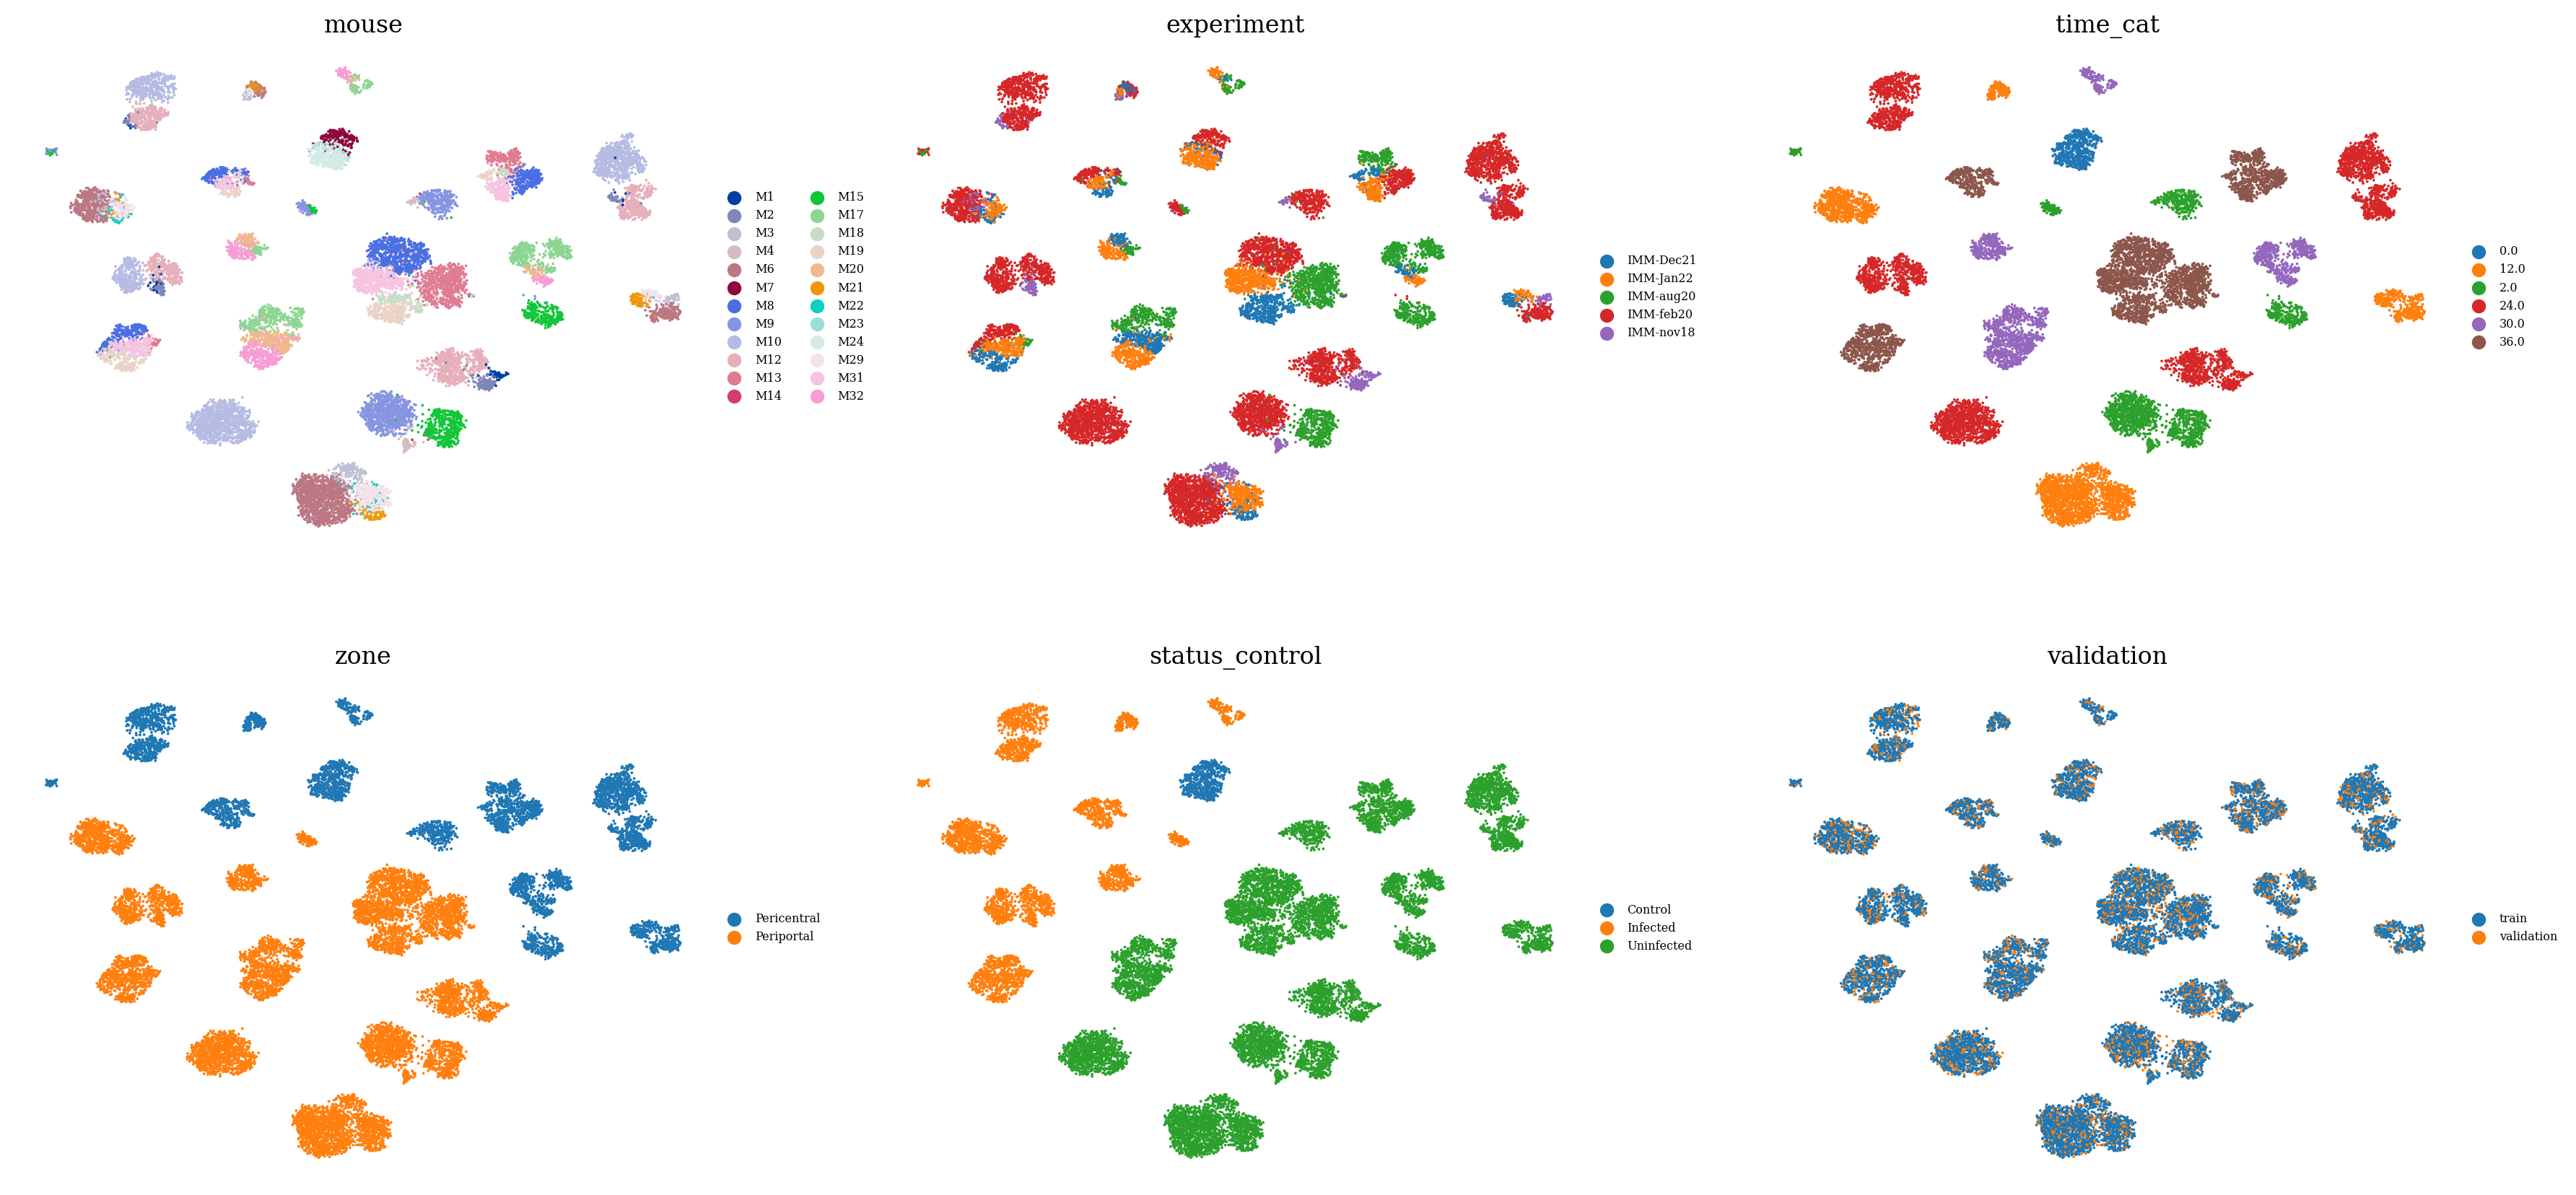

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


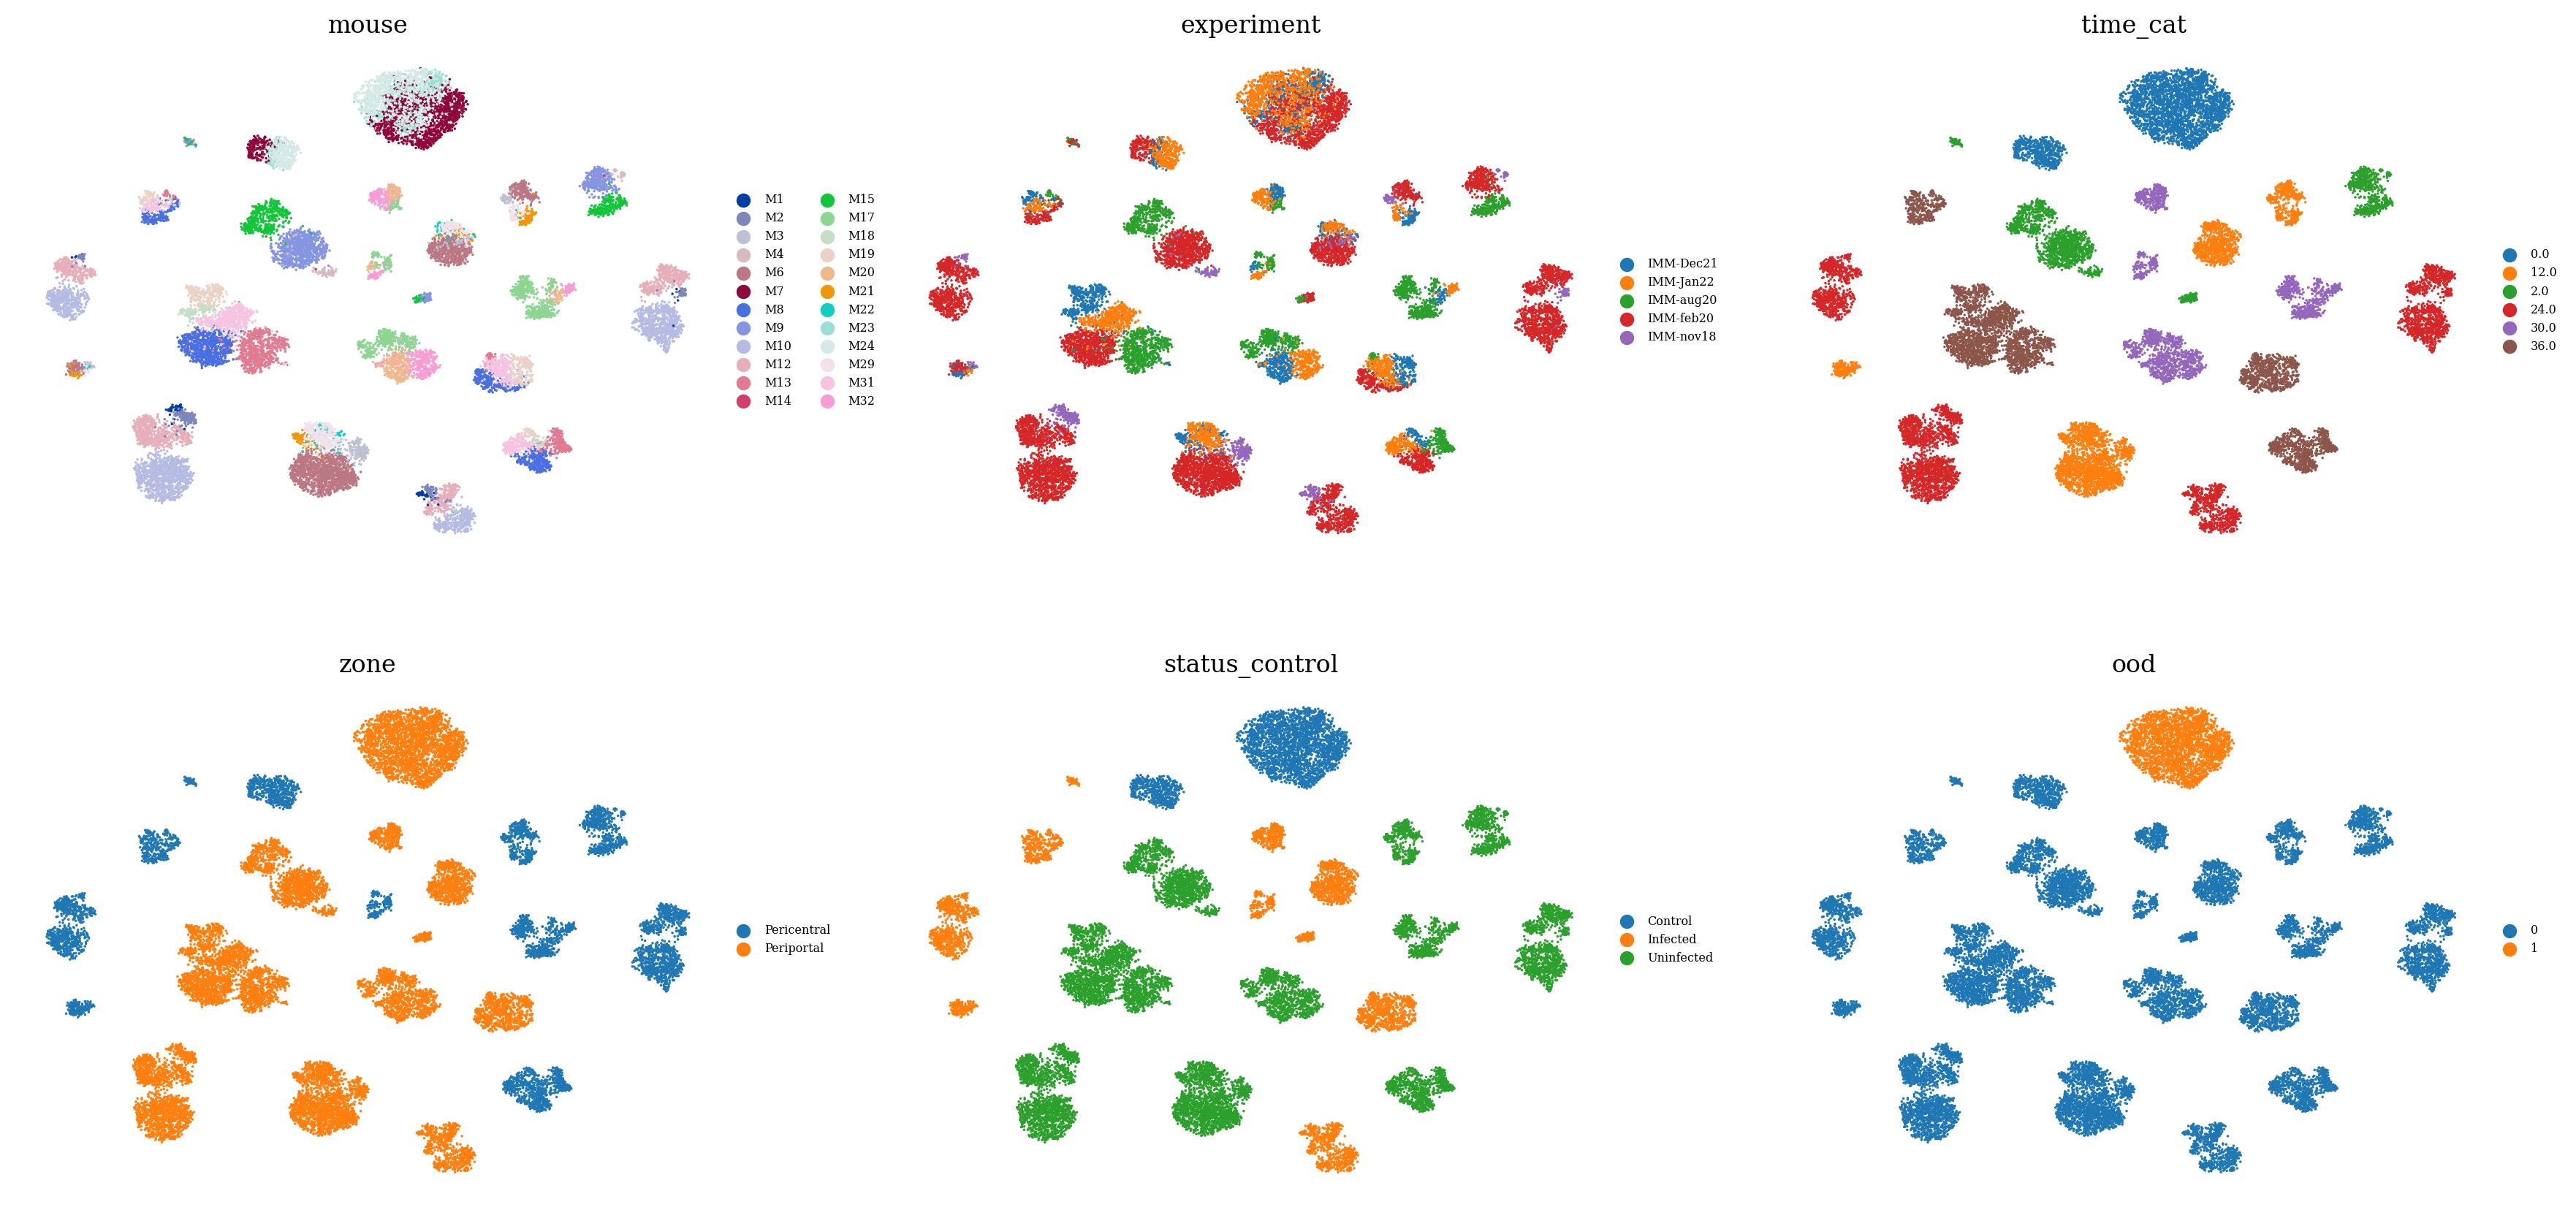

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45252716107699575
F1 Weighted: 0.4527757801521453



{'accuracy': 0.3978939450921399,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.1326313150307133,
 'f1_score_macro': 0.18975876602995245,
 'precision_micro': 0.3978939450921399,
 'recall_micro': 0.3978939450921399,
 'f1_score_micro': 0.3978939450921399,
 'precision_weighted': 1.0,
 'recall_weighted': 0.3978939450921399,
 'f1_score_weighted': 0.5692762980898574,
 'confusion_matrix': array([[1058, 1558,   43],
        [   0,    0,    0],
        [   0,    0,    0]])}

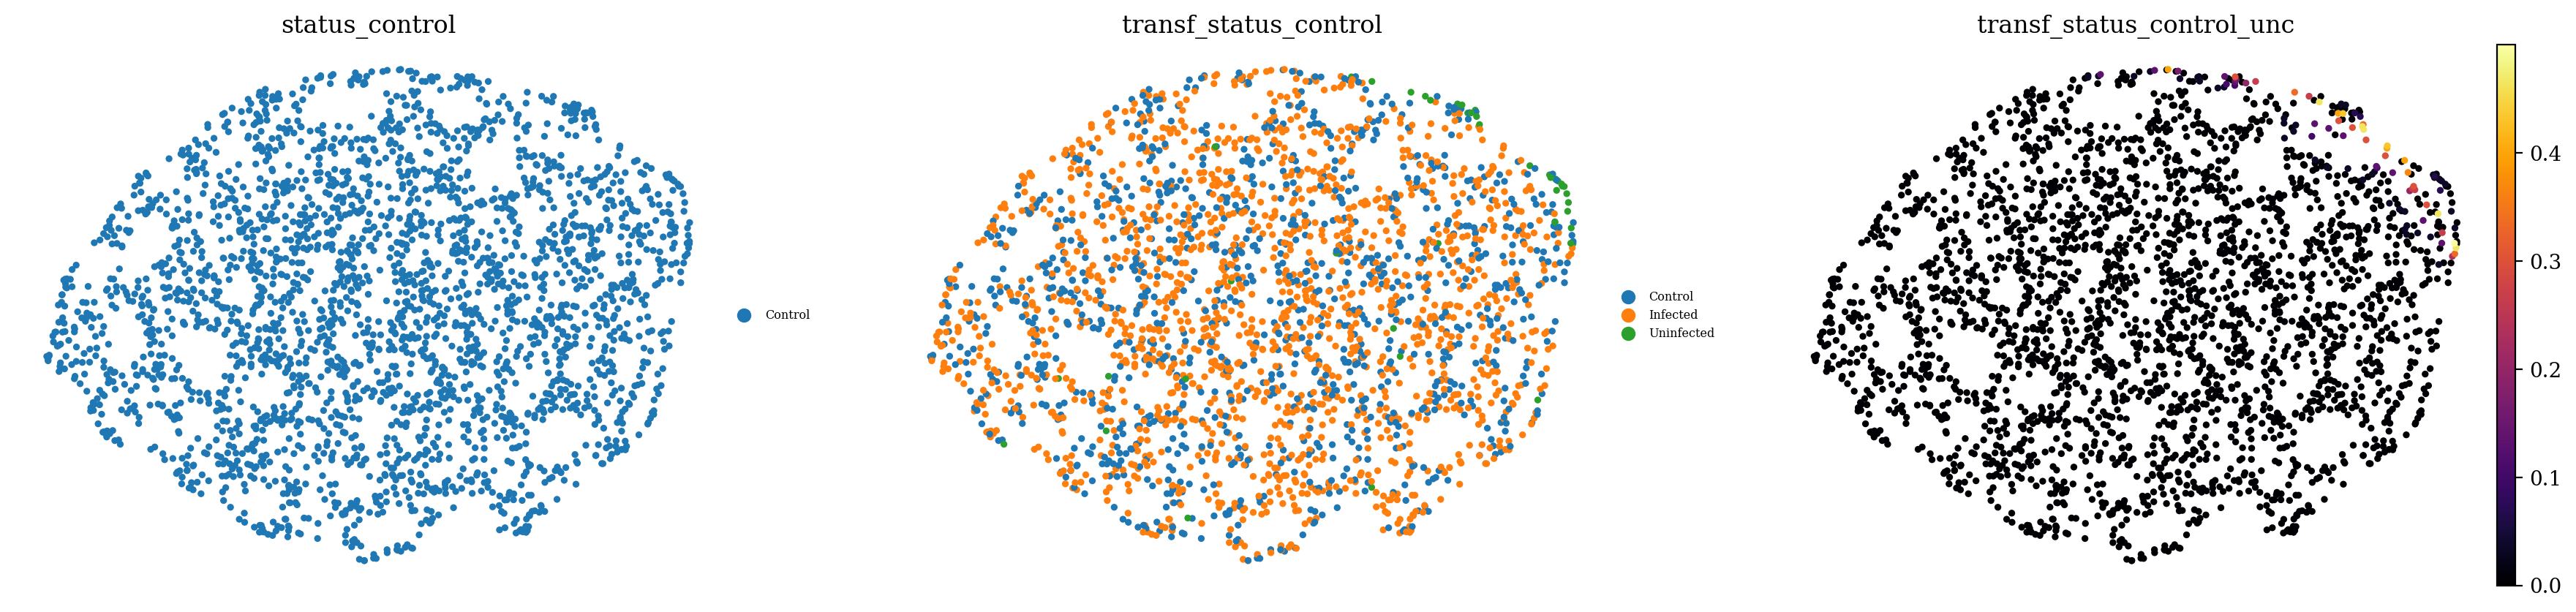

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45347189418989137
F1 Weighted: 0.4537164904295331



{'accuracy': 0.397141782625047,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.132380594208349,
 'f1_score_macro': 0.1895020188425303,
 'precision_micro': 0.397141782625047,
 'recall_micro': 0.397141782625047,
 'f1_score_micro': 0.397141782625047,
 'precision_weighted': 1.0,
 'recall_weighted': 0.397141782625047,
 'f1_score_weighted': 0.5685060565275909,
 'confusion_matrix': array([[1056,  543, 1060],
        [   0,    0,    0],
        [   0,    0,    0]])}